In [1]:
import sys
sys.path.append("..")  # 상위 폴더로 이동
import os
import re
import random
import argparse
import pickle
from tqdm import tqdm
import time
import torch
import torch.nn as nn
import torch.optim as optim
import networkx as nx
import torch.nn.functional as F
import numpy as np
import pandas as pd
import seaborn as sns
import json
from datetime import datetime
import scipy.sparse as sp
import scipy.sparse.linalg as spla
from scipy.sparse.linalg import svds
from scipy.sparse import csr_matrix, coo_matrix
from collections import defaultdict
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from PyPDF2 import PdfMerger
from torch.distributions.normal import Normal
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.utils import from_networkx, to_networkx
from torch_geometric.nn import SAGEConv, GATConv, GCNConv, GraphSAGE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from torch_geometric.transforms import RandomNodeSplit

In [2]:
from utills.function import set_seed, generate_graph_data, generate_noisy_graph_data, load_county_graph_data, load_twitch_graph_data, \
            load_wiki_graph_data, load_trans_graph_data, create_ba_graph_pyg, create_er_graph_pyg, create_grid_graph_pyg, create_tree_graph_pyg, \
            normalize, split_graph_data, split_cp_graph_data, evaluate_model_performance, sort_by_y, coverage_width, \
                get_gpu_memory, get_cpu_memory, count_parameters
from utills.model import GQNN_R, GQNN_N, BayesianGNN, MCDropoutGNN, GQNN, QRLoss, RQRLoss, GQNNLoss

set_seed(1127)  

In [3]:
def load_dataset(dataset):
    if dataset != '':
        if dataset == 'basic':
            graph_data = generate_graph_data(num_nodes=nodes)
        elif dataset in ('gaussian', 'uniform', 'outlier', 'edge'):
            graph_data = generate_noisy_graph_data(num_nodes=nodes, noise_type=dataset, noise_level=noise)
        elif dataset in ('education', 'election', 'income', 'unemployment'):
            graph_data = load_county_graph_data(dataset, 2012)
        elif dataset in ('DE', 'ENGB', 'ES', 'FR', 'PTBR', 'RU'):
            graph_data = load_twitch_graph_data(dataset)
        elif dataset in ('chameleon', 'crocodile', 'squirrel'):
            graph_data = load_wiki_graph_data(dataset)
        elif dataset in ('Anaheim', 'ChicagoSketch'):
            graph_data = load_trans_graph_data(dataset)
        elif dataset == 'BA':
            graph_data = create_ba_graph_pyg(n=nodes)
        elif dataset == 'ER':
            graph_data = create_er_graph_pyg(n=nodes)
        elif dataset == 'grid':
            graph_data = create_grid_graph_pyg()
        elif dataset == 'tree':
            graph_data = create_tree_graph_pyg()
    
    return graph_data

In [4]:
nodes = 1000
noise = 0.3
target_coverage = 0.9
hidden_dim = 64
learning_rate = 1e-3
weight = 1e-3

epochs = 500
runs = 1
lambda_factor = 1
num_samples = 100
dropout = 0.2

device = torch.device('cuda:0')

root_dir = f"./pred/qa/"
os.makedirs(root_dir, exist_ok=True)

In [5]:
pastel_colors = sns.color_palette('muted')
pastel_colors

[(0.2823529411764706, 0.47058823529411764, 0.8156862745098039),
 (0.9333333333333333, 0.5215686274509804, 0.2901960784313726),
 (0.41568627450980394, 0.8, 0.39215686274509803),
 (0.8392156862745098, 0.37254901960784315, 0.37254901960784315),
 (0.5843137254901961, 0.4235294117647059, 0.7058823529411765),
 (0.5490196078431373, 0.3803921568627451, 0.23529411764705882),
 (0.8627450980392157, 0.49411764705882355, 0.7529411764705882),
 (0.4745098039215686, 0.4745098039215686, 0.4745098039215686),
 (0.8352941176470589, 0.7333333333333333, 0.403921568627451),
 (0.5098039215686274, 0.7764705882352941, 0.8862745098039215)]

## Trainig

In [21]:
# dataset_list = ['basic', 'gaussian', 'uniform', 'outlier', 'edge', 'BA', 'ER', 'grid', 'tree']
dataset_list = ['education', 'election', 'income', 'unemployment', 'PTBR', 'chameleon', 'crocodile', 'squirrel', 'Anaheim', 'ChicagoSketch']
method_list = ["SQR", "RQR", "BNN", "MC", "CF", "Qpi"]

In [14]:
all_low_preds = {method: {} for method in method_list}
all_upp_preds = {method: {} for method in method_list}
true_values = {dataset: None for dataset in dataset_list}

for dataset in dataset_list:
    graph_data = load_dataset(dataset)
    train_data, test_data = split_graph_data(graph_data, test_ratio=0.2)
    train_min, train_max, y_min, y_max = train_data.x.min(), train_data.x.max(), train_data.y.min(), train_data.y.max()
    train_data.x, test_data.x, train_data.y, test_data.y= normalize(train_data.x, train_min, train_max), normalize(test_data.x, train_min, train_max), normalize(train_data.y, y_min, y_max), normalize(test_data.y, y_min, y_max)

    in_dim = train_data.x.shape[1]
    train_data = train_data.to(device)
    
    # SQR
    color_sqr = pastel_colors[0]
    tau_low = (1 - target_coverage)/2
    tau_upper = 1 - tau_low
    model = GQNN_R(in_dim=in_dim, hidden_dim=hidden_dim).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight)
    criterion = QRLoss()

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        
        taus = torch.rand(train_data.x.size(0), 1, dtype=torch.float32, device=device)
        preds = model(train_data.x, train_data.edge_index, taus)
        loss = criterion(preds, train_data.y, taus)
            
        loss.backward()
        optimizer.step()

    print('-' * 40, f'{model}: {dataset} Test Evaluation... ', '-' * 40)
    test_data = test_data.to(device)
    tau_lows = torch.full((test_data.x.size(0), 1), tau_low, dtype=torch.float32, device=device)
    tau_uppers = torch.full((test_data.x.size(0), 1), tau_upper, dtype=torch.float32, device=device)

    model.eval()
    with torch.no_grad():
        test_low_preds_sqr = model(test_data.x, test_data.edge_index, tau_lows).cpu().numpy()
        test_upper_preds_sqr = model(test_data.x, test_data.edge_index, tau_uppers).cpu().numpy()
        test_targets_sqr = test_data.y.cpu().numpy()

    all_low_preds["SQR"][dataset] = test_low_preds_sqr
    all_upp_preds["SQR"][dataset] = test_upper_preds_sqr
    true_values[dataset] = test_targets_sqr

    test_eval = evaluate_model_performance(test_low_preds_sqr, test_upper_preds_sqr, test_targets_sqr, target=target_coverage)
        
    # RQR
    color_rqr = pastel_colors[1]
    model = GQNN_N(in_dim=in_dim, hidden_dim=hidden_dim).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight)
    criterion = RQRLoss(target=target_coverage, lambda_factor=lambda_factor)  # lambda_factor 고정함

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        
        preds = model(train_data.x, train_data.edge_index)
        loss = criterion(preds, train_data.y)
            
        loss.backward()
        optimizer.step()


    model.eval()
    test_data = test_data.to(device)

    with torch.no_grad():
        test_preds_rqr = model(test_data.x, test_data.edge_index)
        test_low_preds_rqr = test_preds_rqr[:, 0].cpu().numpy()
        test_upper_preds_rqr = test_preds_rqr[:, 1].cpu().numpy()
        test_targets_rqr = test_data.y.cpu().numpy()
        
    all_low_preds["RQR"][dataset] = test_low_preds_rqr
    all_upp_preds["RQR"][dataset] = test_upper_preds_rqr

    test_eval = evaluate_model_performance(test_low_preds_rqr, test_upper_preds_rqr, test_targets_rqr, target=target_coverage)
        
    # BNN
    color_bnn = pastel_colors[2]
    model = BayesianGNN(in_dim=in_dim, hidden_dim=hidden_dim).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight)

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        
        preds = model(train_data.x, train_data.edge_index)
        loss = F.mse_loss(preds, train_data.y.squeeze())
            
        loss.backward()
        optimizer.step()

    model.eval()

    if target_coverage == 0.9:
        t = 1.645
    elif target_coverage == 0.95:
        t = 1.96
    # 80%: 1.28 / 90%: 1.645 / 95%: 1.96 / 99%: 2.576

    test_data = test_data.to(device)

    preds_list = []
    with torch.no_grad():
        for _ in range(num_samples):
            preds = model(test_data.x, test_data.edge_index)  # Bayesian Sampling
            preds_list.append(preds.cpu().numpy())

    preds_array = np.array(preds_list)  
    mean_preds = preds_array.mean(axis=0)  
    std_preds = preds_array.std(axis=0)    

    test_low_preds_bnn = mean_preds - t * std_preds 
    test_upper_preds_bnn = mean_preds + t * std_preds 
    test_targets_bnn = test_data.y.cpu().numpy()

    all_low_preds["BNN"][dataset] = test_low_preds_bnn
    all_upp_preds["BNN"][dataset] = test_upper_preds_bnn

    test_eval = evaluate_model_performance(test_low_preds_bnn, test_upper_preds_bnn, test_targets_bnn, target=target_coverage)
        
    # MC
    color_mc = pastel_colors[3]
    model = MCDropoutGNN(in_dim=in_dim, hidden_dim=hidden_dim, dropout=dropout).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight)

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        
        preds = model(train_data.x, train_data.edge_index, training=True)
        loss = F.mse_loss(preds, train_data.y.squeeze())
            
        loss.backward()
        optimizer.step()

    model.eval()

    if target_coverage == 0.9:
        t = 1.645
    elif target_coverage == 0.95:
        t = 1.96
        
    test_data = test_data.to(device)

    preds_list = []
    with torch.no_grad():
        for _ in range(num_samples):
            preds = model(test_data.x, test_data.edge_index, training=True)  # Dropout 유지
            preds_list.append(preds.cpu().numpy())

    preds_array = np.array(preds_list)  # (num_samples, num_nodes)
    mean_preds = preds_array.mean(axis=0)  # 평균 예측값
    std_preds = preds_array.std(axis=0)    # 표준편차

    test_low_preds_mc = mean_preds - t * std_preds  # 95% 신뢰구간 하한
    test_upper_preds_mc = mean_preds + t * std_preds  # 95% 신뢰구간 상한
    # test_targets_mc = test_data.y.cpu().numpy()
    test_targets_mc = test_data.y.view(-1).cpu().numpy()

    all_low_preds["MC"][dataset] = test_low_preds_mc
    all_upp_preds["MC"][dataset] = test_upper_preds_mc

    test_eval = evaluate_model_performance(test_low_preds_mc, test_upper_preds_mc, test_targets_mc, target=target_coverage)
        
    # Opi
    color_qpi = pastel_colors[5]

    lf = 0.5
    optimal = True
    if dataset in ['basic', 'gaussian', 'uniform', 'outlier', 'edge', 'BA', 'ER', 'grid', 'tree']:
        df = pd.read_csv("../analysis/lambda/syn/lambda_optimized_results.csv")
        optimal_lambda = df[df['Dataset'] == dataset]['Best Lambda'].values[0]
    else:
        df = pd.read_csv("../analysis/lambda/real/lambda_optimized_results.csv")
        optimal_lambda = df[df['Dataset'] == dataset]['Best Lambda'].values[0]
    if optimal:
        criterion = GQNNLoss(target_coverage=target_coverage, lambda_factor=optimal_lambda)
    else:
        criterion = GQNNLoss(target_coverage=target_coverage, lambda_factor=lf)

    model = GQNN(in_dim=in_dim, hidden_dim=hidden_dim).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight)

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        
        preds_low, preds_upper = model(train_data.x, train_data.edge_index)
        loss = criterion(preds_low, preds_upper, train_data.y)
            
        loss.backward()
        optimizer.step()
        
        cvg, wdt = coverage_width(train_data.y, preds_low, preds_upper)

    model.eval()
    test_data = test_data.to(device)

    with torch.no_grad():
        preds_low, preds_upper = model(test_data.x, test_data.edge_index)    
        test_low_preds_qpi = preds_low.cpu().numpy()
        test_upper_preds_qpi = preds_upper.cpu().numpy()
        test_targets_qpi = test_data.y.cpu().numpy()
        
    all_low_preds["Qpi"][dataset] = test_low_preds_qpi
    all_upp_preds["Qpi"][dataset] = test_upper_preds_qpi

    test_eval = evaluate_model_performance(test_low_preds_qpi, test_upper_preds_qpi, test_targets_qpi, target=target_coverage)

---------------------------------------- GQNN_R(
  (conv1): SAGEConv(7, 64, aggr=mean)
  (conv2): SAGEConv(64, 64, aggr=mean)
  (fc): Linear(in_features=64, out_features=1, bias=True)
): education Test Evaluation...  ----------------------------------------
종합 - CWC ⬇: 0.5480, MCT ⬇: 0.0062
예측 관련 - PICP ⬆: 0.8715, MPE ⬇: 0.0628
구간 관련 - NMPIW ⬇: 0.2352, Sharpness ⬇: 0.0491, WS ⬇: 0.2263
종합 - CWC ⬇: 0.6869, MCT ⬇: 0.0054
예측 관련 - PICP ⬆: 0.9156, MPE ⬇: 0.0894
구간 관련 - NMPIW ⬇: 0.3702, Sharpness ⬇: 0.1192, WS ⬇: 0.3545
종합 - CWC ⬇: 4.1114, MCT ⬇: 0.2803
예측 관련 - PICP ⬆: 1.0000, MPE ⬇: 0.3399
구간 관련 - NMPIW ⬇: 3.0057, Sharpness ⬇: 7.8543, WS ⬇: 2.8025
종합 - CWC ⬇: 2.9219, MCT ⬇: 0.0349
예측 관련 - PICP ⬆: 0.5836, MPE ⬇: 0.0571
구간 관련 - NMPIW ⬇: 0.1185, Sharpness ⬇: 0.0137, WS ⬇: 0.1290
종합 - CWC ⬇: 0.7630, MCT ⬇: 0.0500
예측 관련 - PICP ⬆: 0.9969, MPE ⬇: 0.1017
구간 관련 - NMPIW ⬇: 0.5531, Sharpness ⬇: 0.2749, WS ⬇: 0.5158
---------------------------------------- GQNN_R(
  (conv1): SAGEConv(7, 64, aggr=mean)


/home/sypark/QpiGNN/training/../utills/function.py:388: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  pyg_data.x = torch.tensor(feats, dtype=torch.float)


---------------------------------------- GQNN_R(
  (conv1): SAGEConv(3171, 64, aggr=mean)
  (conv2): SAGEConv(64, 64, aggr=mean)
  (fc): Linear(in_features=64, out_features=1, bias=True)
): PTBR Test Evaluation...  ----------------------------------------
종합 - CWC ⬇: 27.4891, MCT ⬇: 0.0153
예측 관련 - PICP ⬆: 0.1728, MPE ⬇: 0.0417
구간 관련 - NMPIW ⬇: 0.0191, Sharpness ⬇: 0.0005, WS ⬇: 0.0531
종합 - CWC ⬇: 1.0132, MCT ⬇: 0.0162
예측 관련 - PICP ⬆: 0.8649, MPE ⬇: 0.1194
구간 관련 - NMPIW ⬇: 0.4185, Sharpness ⬇: 0.2120, WS ⬇: 0.4721
종합 - CWC ⬇: 3.8411, MCT ⬇: 0.3088
예측 관련 - PICP ⬆: 1.0000, MPE ⬇: 0.1866
구간 관련 - NMPIW ⬇: 2.8081, Sharpness ⬇: 9.5345, WS ⬇: 3.0878
종합 - CWC ⬇: 0.6549, MCT ⬇: 0.0188
예측 관련 - PICP ⬆: 0.7277, MPE ⬇: 0.0434
구간 관련 - NMPIW ⬇: 0.0992, Sharpness ⬇: 0.0140, WS ⬇: 0.1207
종합 - CWC ⬇: 0.6153, MCT ⬇: 0.0002
예측 관련 - PICP ⬆: 0.9005, MPE ⬇: 0.0821
구간 관련 - NMPIW ⬇: 0.3085, Sharpness ⬇: 0.1273, WS ⬇: 0.3462
---------------------------------------- GQNN_R(
  (conv1): SAGEConv(3133, 64, aggr=mean

In [15]:
# CF-GNN
import argparse
import os.path as osp
from tqdm import tqdm
import torch
import torch.nn.functional as F
import torch.nn as nn
import numpy as np
import pandas as pd
import copy
import os
import wandb
import pickle
import sys 

sys.path.append('..')
from utills.function import generate_graph_data, generate_noisy_graph_data, load_county_graph_data, load_twitch_graph_data, \
            load_wiki_graph_data, load_trans_graph_data, create_ba_graph_pyg, create_er_graph_pyg, create_grid_graph_pyg, create_tree_graph_pyg
            
from torch_geometric.logging import log
from torch_geometric.data import Data
from scipy.stats import pearsonr
import torch_geometric.transforms as T

from conformalized_gnn.model import GNN, ConfMLP, GNN_Multi_Layer
from conformalized_gnn.calibrator import TS, VS, ETS, CaGCN, GATS
from conformalized_gnn.conformal import run_conformal_regression

hidden_channels = 64
model = 'GraphSAGE'
heads = 1
aggr = 'sum'
alpha = 0.1
lr = 1e-3
epochs = 500
conformal_score = 'cqr'
conftr = False
conftr_holdout = False
conftr_calib_holdout = False
conftr_valid_holdout = False
conftr_sep_test = False
conf_correct_model = 'gnn'
calibrator = 'NULL'
quantile = False
bnn = False
target_size = 0
confnn_hidden_dim = 64
confgnn_num_layers = 1
confgnn_base_model = 'GCN'
confgnn_lr = 1e-3
tau = 0.1
size_loss_weight = 1
reg_loss_weight = 1
not_save_res = False
num_runs = 1
retrain = False
verbose = False
data_seed = 0
cond_cov_loss = False
calib_fraction = 0.5
optimize_conformal_score = 'aps'
task = 'regression'
metric = 'eff_valid_cqr'
optimal = True


class GNN_gf(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, backbone, heads = 1, aggr = 'sum'):
        super().__init__()
        if backbone == 'GCN':
            self.conv1 = GCNConv(in_channels, hidden_channels, cached=True,
                             normalize=True)
            self.conv2 = GCNConv(hidden_channels, out_channels, cached=True,
                             normalize=True)
        elif backbone == 'GAT':
            self.conv1 = GATConv(in_channels, hidden_channels, heads)
            self.conv2 = GATConv(hidden_channels, out_channels, heads)
        elif backbone == 'GraphSAGE':
            self.conv1 = SAGEConv(in_channels, hidden_channels, aggr)
            self.conv2 = SAGEConv(hidden_channels, out_channels, aggr)
        elif backbone == 'SGC':
            self.conv1 = SGConv(in_channels, hidden_channels)
            self.conv2 = SGConv(hidden_channels, out_channels)
        
    def forward(self, x, edge_index, edge_weight=None, return_h = False):
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv1(x, edge_index, edge_weight).relu()
        if return_h:
            return x
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index, edge_weight)
        return x
    
class ConfGNN(torch.nn.Module):
    def __init__(self, model, dataset, confnn_hidden_dim, heads, aggr, num_conf_layers, base_model, output_dim, task):
        super().__init__()
        self.model = model
        #num_classes = max(dataset.y).item() + 1
        #print(base_model)
        self.confgnn = GNN_Multi_Layer(output_dim, confnn_hidden_dim, output_dim, base_model, heads, aggr, num_conf_layers)  
        self.task = task
        
    def forward(self, x, edge_index):
        with torch.no_grad():
            scores = self.model(x, edge_index)
        if self.task == 'regression':
            out = scores
        else:
            out = F.softmax(scores, dim = 1)
        adjust_scores = self.confgnn(out, edge_index)
        return adjust_scores, scores

if conformal_score != 'cqr':
    raise ValueError('For regression task, the training conformal score should be cqr!')

if bnn:
    quantile = False
else:    
    quantile = True 
    
if dataset == 'basic':
    graph_data = generate_graph_data(num_nodes=nodes)
elif dataset in ('gaussian', 'uniform', 'outlier', 'edge'):
    graph_data = generate_noisy_graph_data(num_nodes=nodes, noise_type=dataset, noise_level=noise)
elif dataset in ('education', 'election', 'income', 'unemployment'):
    graph_data = load_county_graph_data(dataset, 2012)
elif dataset in ('DE', 'ENGB', 'ES', 'FR', 'PTBR', 'RU'):
    graph_data = load_twitch_graph_data(dataset)
elif dataset in ('chameleon', 'crocodile', 'squirrel'):
    graph_data = load_wiki_graph_data(dataset)
elif dataset in ('Anaheim', 'ChicagoSketch'):
    graph_data = load_trans_graph_data(dataset)
elif dataset == 'BA':
    graph_data = create_ba_graph_pyg(n=nodes)
elif dataset == 'ER':
    graph_data = create_er_graph_pyg(n=nodes)
elif dataset == 'grid':
    graph_data = create_grid_graph_pyg()
elif dataset == 'tree':
    graph_data = create_tree_graph_pyg()
    
def gaussian_nll_loss(mean, log_var, y_true):
    # Compute the negative log likelihood for a Gaussian distribution
    precision = torch.exp(-log_var)
    mse_loss = F.mse_loss(mean, y_true, reduction='none')
    nll_loss = 0.5 * (mse_loss * precision + log_var + torch.log(torch.tensor(2 * np.pi)))
    return torch.mean(nll_loss)

def train(epoch, model, data, optimizer, alpha):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index, data.edge_attr)

    if quantile:
        mid = out[:, 0][data.train_mask].reshape(-1,1)
        label = data.y[data.train_mask].reshape(-1,1)
        mse_loss = F.mse_loss(mid, label)
        low_bound = alpha/2
        upp_bound = 1 - alpha/2
        lower = out[:, 1][data.train_mask].reshape(-1,1)
        upper = out[:, 2][data.train_mask].reshape(-1,1)
        low_loss = torch.mean(torch.max((low_bound - 1) * (label - lower), low_bound * (label - lower)))
        upp_loss = torch.mean(torch.max((upp_bound - 1) * (label - upper), upp_bound * (label - upper)))
        loss = mse_loss + low_loss + upp_loss
    elif bnn:
        mu = out[:, 0][data.train_mask].reshape(-1,1)
        logvar = out[:, 1][data.train_mask].reshape(-1,1)
        loss = gaussian_nll_loss(mu, logvar, data.y[data.train_mask])
    else:
        loss = F.mse_loss(out[data.train_mask], data.y[data.train_mask])
        
    loss.backward()
    optimizer.step()
    
    if quantile:
        return (float(loss), mse_loss, low_loss, upp_loss)
    elif bnn:
        return float(loss)
    else:
        return float(loss)

@torch.no_grad()
def test(model, data, alpha, tau, target_size, size_loss = False):
    model.eval()
    
    if size_loss:
        pred_raw, ori_pred_raw = model(data.x, data.edge_index)
    else:
        pred_raw = model(data.x, data.edge_index)
        
    if quantile:
        pred = pred_raw[:, 0]
    elif bnn:
        pred = pred_raw[:, 0]
    else:
        pred = pred_raw
        
    accs = []
    for mask in [data.train_mask, data.valid_mask, data.calib_test_mask]:
        accs.append(pearsonr(pred[mask].detach().cpu().numpy().reshape(-1), 
                             data.y[mask].detach().cpu().numpy().reshape(-1))[0])
    if size_loss:
        if task == 'regression':
            if quantile:
                query_idx = np.where(data.valid_mask)[0]
                np.random.seed(0)
                np.random.shuffle(query_idx)

                train_train_idx = query_idx[:int(len(query_idx)/2)]
                train_calib_idx = query_idx[int(len(query_idx)/2):]
                
                n_temp = len(train_calib_idx)
                ### use only train_train nodes
                mid = pred_raw[:, 0][train_calib_idx].reshape(-1,1)
                label = data.y[train_calib_idx].reshape(-1,1)
                mse_loss = F.mse_loss(mid, label)
                low_bound = alpha/2
                upp_bound = 1 - alpha/2
                lower = pred_raw[:, 1][train_calib_idx].reshape(-1,1)
                upper = pred_raw[:, 2][train_calib_idx].reshape(-1,1)
                low_loss = torch.mean(torch.max((low_bound - 1) * (label - lower), low_bound * (label - lower)))
                upp_loss = torch.mean(torch.max((upp_bound - 1) * (label - upper), upp_bound * (label - upper)))
                
                ## CQR loss
                size_loss = 0
                lower_calib = pred_raw[:, 1][train_train_idx].reshape(-1,1)
                upper_calib = pred_raw[:, 2][train_train_idx].reshape(-1,1)
                label_calib = data.y[train_train_idx].reshape(-1,1)

                cal_scores = torch.maximum(label_calib-upper_calib, lower_calib-label_calib)
                # Get the score quantile
                qhat = torch.quantile(cal_scores, np.ceil((n_temp+1)*(1-alpha))/n_temp, interpolation='higher')
                size_loss = torch.mean(upper_calib + qhat - (lower_calib - qhat))
                pred_loss = mse_loss + low_loss + upp_loss
        elif bnn:
            raise ValueError('Not implemented....')
        else:
            out_softmax = F.softmax(pred_raw, dim = 1)
            query_idx = np.where(data.valid_mask)[0]
            np.random.seed(0)
            np.random.shuffle(query_idx)

            train_train_idx = query_idx[:int(len(query_idx)/2)]
            train_calib_idx = query_idx[int(len(query_idx)/2):]

            n_temp = len(train_calib_idx)
            q_level = np.ceil((n_temp+1)*(1-alpha))/n_temp

            tps_conformal_score = out_softmax[train_calib_idx][torch.arange(len(train_calib_idx)), data.y[train_calib_idx]]
            qhat = torch.quantile(tps_conformal_score, 1 - q_level, interpolation='higher')
            c = torch.sigmoid((out_softmax[train_train_idx] - qhat)/tau)
            size_loss = torch.mean(torch.relu(torch.sum(c, axis = 1) - target_size))
            
        return accs, pred_raw, size_loss.item()
    else:
        return accs, pred_raw  

data = Data(x=graph_data.x, edge_index=graph_data.edge_index, y=graph_data.y)
x = data.x
y = data.y
    
idx = np.array(range(len(y)))  
np.random.seed(data_seed)
np.random.shuffle(idx)
split_res = np.split(idx, [int(0.5 * len(idx)), int(0.6 * len(idx)), len(idx)])
train_idx, valid, calib_test = split_res[0], split_res[1], split_res[2]

data.train_mask = np.array([False] * len(y)) 
data.train_mask[train_idx] = True

data.valid_mask = np.array([False] * len(y)) 
data.valid_mask[valid] = True

data.calib_test_mask = np.array([False] * len(y)) 
data.calib_test_mask[calib_test] = True

n_trials = 100
n = min(1000, int(calib_test.shape[0]/2))
alpha = alpha
tau = tau
target_size = target_size
num_conf_layers = confgnn_num_layers
base_model = confgnn_base_model
tau2res = {}   

In [16]:
# CF-GNN
dataset_list = ['education', 'election', 'income', 'unemployment', 'PTBR','Anaheim', 'ChicagoSketch']
optimal = True

for dataset in dataset_list:    
    graph_data = load_dataset(dataset)
    data = Data(x=graph_data.x, edge_index=graph_data.edge_index, y=graph_data.y)
    x = data.x
    y = data.y
    
    idx = np.array(range(len(y)))  
    np.random.seed(data_seed)
    np.random.shuffle(idx)
    split_res = np.split(idx, [int(0.5 * len(idx)), int(0.6 * len(idx)), len(idx)])
    train_idx, valid, calib_test = split_res[0], split_res[1], split_res[2]

    data.train_mask = np.array([False] * len(y)) 
    data.train_mask[train_idx] = True

    data.valid_mask = np.array([False] * len(y)) 
    data.valid_mask[valid] = True

    data.calib_test_mask = np.array([False] * len(y)) 
    data.calib_test_mask[calib_test] = True
    
    n_trials = 100
    n = min(1000, int(calib_test.shape[0]/2))
    alpha = alpha
    tau = tau
    target_size = target_size
    num_conf_layers = confgnn_num_layers
    base_model = confgnn_base_model
    
    color_cf = pastel_colors[4]
    
    for run in tqdm(range(num_runs)):
        result_this_run = {}
        
        if quantile:
            output_dim = 3
        elif bnn:
            output_dim = 2
        else:
            output_dim = 1
        num_features = x.shape[1]

        print('training base model from scratch...')
        model = GNN_gf(num_features, hidden_channels, output_dim, 'GraphSAGE', heads, aggr)    
        
        model, data = model.to(device), data.to(device)
        optimizer = torch.optim.Adam([
            dict(params=model.conv1.parameters(), weight_decay=1e-3),
            dict(params=model.conv2.parameters(), weight_decay=0)
        ], lr=lr)  # Only perform weight-decay on first convolution.

        best_val_acc = final_test_acc = 0
        
        torch.cuda.reset_peak_memory_stats()
        start_time = time.time()
        
        for epoch in range(1, epochs + 1):
            loss = train(epoch, model, data, optimizer, alpha)
            if quantile:
                mse = loss[1]
                lower = loss[2]
                upper = loss[3]
                loss = loss[0]
            
            (train_acc, val_acc, tmp_test_calib_acc), pred = test(model, data, alpha, tau, target_size)
            
            if val_acc > best_val_acc:
                #torch.save(best_model, model_checkpoint)
                best_model = copy.deepcopy(model)
                best_val_acc = val_acc
                test_acc = tmp_test_calib_acc
                best_pred = pred
                
            if quantile:
                if verbose:
                    log(Epoch=epoch, Loss=loss, Train=train_acc, Val=val_acc, Calib_Test=tmp_test_calib_acc, upper=upper, lower=lower, mse=mse)
            else:
                if verbose:
                    log(Epoch=epoch, Loss=loss, Train=train_acc, Val=val_acc, Calib_Test=tmp_test_calib_acc)

        # torch.save(best_model, model_checkpoint)
        # pred = best_pred
        pred = best_pred if 'best_pred' in locals() else pred

        (train_acc, val_acc, test_acc), _ = test(best_model, data, alpha, tau, target_size, size_loss = False)
        
        result_this_run['gnn'] = {}
            
        if task == 'regression':
            result_this_run['gnn']['CQR'] = run_conformal_regression(pred, data, n, alpha, calib_eval = False)

        condcov_epochs = []
        result_this_run['conf_gnn'] = {}

        model_to_correct = copy.deepcopy(model)
        if conf_correct_model == 'gnn':
            confmodel = ConfGNN(model_to_correct, data, confnn_hidden_dim, heads, aggr, num_conf_layers, base_model, output_dim, task).to(device)
        optimizer = torch.optim.Adam(confmodel.parameters(), weight_decay=1e-3, lr=confgnn_lr)  # Only perform weight-decay on first convolution.
        pred_loss_hist, size_loss_hist, cons_loss_hist, val_size_loss_hist = [], [], [], []
        best_size_loss = 10000
        best_val_acc = 0

        if conftr_calib_holdout:
            calib_test_idx = np.where(data.calib_test_mask)[0]
            np.random.seed(run)
            np.random.shuffle(calib_test_idx)
            calib_eval_idx = calib_test_idx[:int(n * calib_fraction)]
            calib_test_real_idx = calib_test_idx[int(n * calib_fraction):]

            data.calib_eval_mask = np.array([False] * len(y))
            data.calib_eval_mask[calib_eval_idx] = True
            data.calib_test_real_mask = np.array([False] * len(y))
            data.calib_test_real_mask[calib_test_real_idx] = True
            
            if verbose:
                print('Using a separate calibration holdout...')
            calib_eval_idx = np.where(data.calib_eval_mask)[0]
            np.random.seed(run)
            np.random.shuffle(calib_eval_idx)
            train_calib_idx = calib_eval_idx[int(len(calib_eval_idx)/2):]
            train_test_idx = calib_eval_idx[:int(len(calib_eval_idx)/2)]
            train_train_idx = np.where(data.train_mask)[0]

        if conftr_valid_holdout:
            if verbose:
                print('Using the validation set as holdout...')
            calib_eval_idx = np.where(data.valid_mask)[0]
            np.random.seed(run)
            np.random.shuffle(calib_eval_idx)
            train_calib_idx = calib_eval_idx[int(len(calib_eval_idx)/2):]
            train_test_idx = calib_eval_idx[:int(len(calib_eval_idx)/2)]
            train_train_idx = np.where(data.train_mask)[0]

        if conftr_holdout:
            train_idx = np.where(data.train_mask)[0]
            np.random.seed(run)
            np.random.shuffle(train_idx)

            train_train_idx = train_idx[:int(len(train_idx)/2)]

            if conftr_sep_test:
                train_calib_test_idx = train_idx[int(len(train_idx)/2):]
                np.random.seed(run)
                np.random.shuffle(train_calib_test_idx)
                train_calib_idx = train_calib_test_idx[int(len(train_calib_test_idx)/2):]
                train_test_idx = train_calib_test_idx[:int(len(train_calib_test_idx)/2)]
            else:
                train_calib_idx = train_idx[int(len(train_idx)/2):]
                train_test_idx = train_train_idx
        
        print('Starting topology-aware conformal correction...')
        
        for epoch in range(1, epochs + 1):  
            if (not conftr_holdout) and (not conftr_calib_holdout) and (not conftr_valid_holdout):
                train_idx = np.where(data.train_mask)[0]
                np.random.seed(epoch)
                np.random.shuffle(train_idx)
                train_train_idx = train_idx[:int(len(train_idx)/2)]
                train_calib_idx = train_idx[int(len(train_idx)/2):]
                train_test_idx = train_train_idx

            confmodel.train()
            optimizer.zero_grad()
            out, ori_out = confmodel(data.x, data.edge_index)
            if task == 'regression':
                if quantile:
                    ### use only train_train nodes
                    mid = out[:, 0][train_train_idx].reshape(-1,1)
                    label = data.y[train_train_idx].reshape(-1,1)
                    mse_loss = F.mse_loss(mid, label)
                    low_bound = alpha/2
                    upp_bound = 1 - alpha/2
                    lower = out[:, 1][train_train_idx].reshape(-1,1)
                    upper = out[:, 2][train_train_idx].reshape(-1,1)
                    low_loss = torch.mean(torch.max((low_bound - 1) * (label - lower), low_bound * (label - lower)))
                    upp_loss = torch.mean(torch.max((upp_bound - 1) * (label - upper), upp_bound * (label - upper)))
                    pred_loss = mse_loss + low_loss + upp_loss

                    n_temp = len(train_calib_idx)
                    ## CQR loss
                    lower_calib = out[:, 1][train_calib_idx].reshape(-1,1)
                    upper_calib = out[:, 2][train_calib_idx].reshape(-1,1)
                    label_calib = data.y[train_calib_idx].reshape(-1,1)

                    cal_scores = torch.maximum(label_calib-upper_calib, lower_calib-label_calib)
                    # Get the score quantile
                    qhat = torch.quantile(cal_scores, np.ceil((n_temp+1)*(1-alpha))/n_temp, interpolation='higher')

                    lower_test = out[:, 1][train_test_idx].reshape(-1,1)
                    upper_test = out[:, 2][train_test_idx].reshape(-1,1)
                    
                    lower_deviate_loss = F.mse_loss(out[:, 1].reshape(-1,1), ori_out[:, 1].reshape(-1,1))
                    upper_deviate_loss = F.mse_loss(out[:, 2].reshape(-1,1), ori_out[:, 2].reshape(-1,1))
                                            
                    size_loss = torch.mean(upper_test + qhat - (lower_test - qhat))

                if conftr:
                    if epoch <= 1000:
                        loss = pred_loss
                    else:
                        loss = pred_loss + size_loss_weight * size_loss
                        loss += reg_loss_weight + lower_deviate_loss
                        loss += reg_loss_weight + upper_deviate_loss
                else:
                    loss = pred_loss

            else:
                out_softmax = F.softmax(out, dim = 1)
                ori_out_softmax = F.softmax(ori_out, dim = 1)

                n_temp = len(train_calib_idx)
                q_level = np.ceil((n_temp+1)*(1-alpha))/n_temp

                tps_conformal_score = out_softmax[train_calib_idx][torch.arange(len(train_calib_idx)), data.y[train_calib_idx]]
                qhat = torch.quantile(tps_conformal_score, 1 - q_level, interpolation='higher')

                c = torch.sigmoid((out_softmax[train_test_idx] - qhat)/tau)
                size_loss = torch.mean(torch.relu(torch.sum(c, axis = 1) - target_size))
                if cond_cov_loss:
                    ## coverage loss
                    unique_classes = torch.unique(data.y)
                    y = data.y[train_test_idx]
                    loss_cov = torch.zeros(1).to(device)
                    for i in unique_classes:
                        class_mask = y == i
                        loss_cov += -torch.mean(c[torch.arange(c.shape[0]), y][class_mask])
                    loss_cov = (1/len(unique_classes)) * loss_cov

                    loss_cov = loss_cov.squeeze()
                    #print(loss_cov.item())
                    #print(run_conformal_classification(out, data, n, alpha, score = 'aps', validation_set = True))
                pred_loss = F.cross_entropy(out[train_train_idx], data.y[train_train_idx])

                if conftr:
                    if epoch <= 1000:
                        loss = pred_loss
                    elif cond_cov_loss:
                        if epoch <=3000:
                            loss = pred_loss + size_loss_weight * size_loss
                        else:
                            loss = pred_loss + size_loss_weight * size_loss + loss_cov
                    else:
                        loss = pred_loss + size_loss_weight * size_loss
                else:
                    loss = pred_loss
                
            loss.backward()
            optimizer.step()
            loss = float(loss)
            
            pred_loss_hist.append(pred_loss.item())
            size_loss_hist.append(size_loss.item())
            
            (train_acc, val_acc, tmp_test_calib_acc), pred, size_loss = test(confmodel, data, alpha, tau, target_size, size_loss = True)
            
            if task == 'regression':
                eff_valid = run_conformal_regression(pred, data, n, alpha, validation_set = True)[1]
            else:
                eff_valid = run_conformal_classification(pred, data, n, alpha, score = 'aps', validation_set = True)[1]
                
            val_size_loss_hist.append(size_loss)
            if conftr:
                if eff_valid < best_size_loss: 
                    best_size_loss = eff_valid
                    test_acc = tmp_test_calib_acc
                    best_pred = pred
                    best_epoch = epoch
            else:
                if val_acc > best_val_acc:
                    best_val_acc = val_acc
                    test_acc = tmp_test_calib_acc
                    best_pred = pred    

        result_this_run['conf_gnn'] = {}
        
        if task == 'regression':
            result_this_run['conf_gnn']['CQR'] = run_conformal_regression(best_pred, data, n, alpha, calib_eval = conftr_calib_holdout, calib_fraction = calib_fraction)
            result_this_run['conf_gnn']['eff_valid'] = run_conformal_regression(best_pred, data, n, alpha, validation_set = True)[1]
            
            # 추가한 평가 코드
            # print('-' * 40, f'CF-GNN: {dataset} Train Evaluation... ', '-' * 40)
            # result_this_run['train_metrics'] = run_conformal_regression(best_pred, data, n, alpha, calib_eval = conftr_calib_holdout, calib_fraction = calib_fraction, 
            #                                                             train_set=True, evaluate=True, target = 1-alpha)
            
            print('-' * 40, f'CF-GNN: {dataset} Test Evaluation... ', '-' * 40)
            result_this_run['test_metrics'] = run_conformal_regression(best_pred, data, n, alpha, calib_eval = conftr_calib_holdout, calib_fraction = calib_fraction, 
                                                                        evaluate=True, target = 1-alpha) 
            
            cov_all, eff_all, pred_set_all, val_labels_all, idx_all = run_conformal_regression(best_pred, data, n, alpha, return_prediction_sets = True)
            
        tau2res[run] = result_this_run
        print('Finished training this run!')   
        
    test_preds_low_cf = np.array(pred_set_all[0][0])
    test_preds_upper_cf = np.array(pred_set_all[0][1])
    test_targets_cf = np.array(val_labels_all[0])

    all_low_preds["CF"][dataset] = test_preds_low_cf
    all_upp_preds["CF"][dataset] = test_preds_upper_cf

  0%|          | 0/1 [00:00<?, ?it/s]

training base model from scratch...
Starting topology-aware conformal correction...


100%|██████████| 1/1 [00:17<00:00, 17.78s/it]

---------------------------------------- CF-GNN: education Test Evaluation...  ----------------------------------------
종합 - CWC ⬇: 0.7966, MCT ⬇: 0.0358
예측 관련 - PICP ⬆: 0.8872, MPE ⬇: 0.8015
구간 관련 - NMPIW ⬇: 0.3728, Sharpness ⬇: 8.2579, WS ⬇: 2.8658
Finished training this run!



  0%|          | 0/1 [00:00<?, ?it/s]

training base model from scratch...
Starting topology-aware conformal correction...


100%|██████████| 1/1 [00:18<00:00, 18.15s/it]

---------------------------------------- CF-GNN: election Test Evaluation...  ----------------------------------------
종합 - CWC ⬇: 1.2721, MCT ⬇: 0.0128
예측 관련 - PICP ⬆: 0.8872, MPE ⬇: 0.2537
구간 관련 - NMPIW ⬇: 0.5953, Sharpness ⬇: 1.0298, WS ⬇: 1.0128
Finished training this run!



  0%|          | 0/1 [00:00<?, ?it/s]

training base model from scratch...
Starting topology-aware conformal correction...


100%|██████████| 1/1 [00:18<00:00, 18.74s/it]

---------------------------------------- CF-GNN: income Test Evaluation...  ----------------------------------------
종합 - CWC ⬇: 0.6715, MCT ⬇: 0.0284
예측 관련 - PICP ⬆: 0.9119, MPE ⬇: 0.5165
구간 관련 - NMPIW ⬇: 0.3557, Sharpness ⬇: 7.0173, WS ⬇: 2.4133
Finished training this run!



  0%|          | 0/1 [00:00<?, ?it/s]

training base model from scratch...
Starting topology-aware conformal correction...


100%|██████████| 1/1 [00:18<00:00, 18.33s/it]

---------------------------------------- CF-GNN: unemployment Test Evaluation...  ----------------------------------------
종합 - CWC ⬇: 0.7943, MCT ⬇: 0.0527
예측 관련 - PICP ⬆: 0.9165, MPE ⬇: 0.8021
구간 관련 - NMPIW ⬇: 0.4299, Sharpness ⬇: 10.2055, WS ⬇: 3.2733
Finished training this run!



  0%|          | 0/1 [00:00<?, ?it/s]

training base model from scratch...
Starting topology-aware conformal correction...


100%|██████████| 1/1 [00:18<00:00, 18.78s/it]

---------------------------------------- CF-GNN: PTBR Test Evaluation...  ----------------------------------------
종합 - CWC ⬇: 1.1072, MCT ⬇: 0.1665
예측 관련 - PICP ⬆: 0.9478, MPE ⬇: 0.7507
구간 관련 - NMPIW ⬇: 0.6834, Sharpness ⬇: 12.2638, WS ⬇: 3.5038
Finished training this run!



  0%|          | 0/1 [00:00<?, ?it/s]

training base model from scratch...
Starting topology-aware conformal correction...


100%|██████████| 1/1 [00:16<00:00, 16.22s/it]

---------------------------------------- CF-GNN: Anaheim Test Evaluation...  ----------------------------------------
종합 - CWC ⬇: 1.1451, MCT ⬇: 0.0045
예측 관련 - PICP ⬆: 0.9016, MPE ⬇: 0.9589
구간 관련 - NMPIW ⬇: 0.5772, Sharpness ⬇: 8.6232, WS ⬇: 2.7791
Finished training this run!



  0%|          | 0/1 [00:00<?, ?it/s]

training base model from scratch...
Starting topology-aware conformal correction...


100%|██████████| 1/1 [00:17<00:00, 17.06s/it]

---------------------------------------- CF-GNN: ChicagoSketch Test Evaluation...  ----------------------------------------
종합 - CWC ⬇: 0.9428, MCT ⬇: 0.0586
예측 관련 - PICP ⬆: 0.8807, MPE ⬇: 0.7307
구간 관련 - NMPIW ⬇: 0.4262, Sharpness ⬇: 9.2786, WS ⬇: 3.1335
Finished training this run!


## 시각화

In [17]:
from seaborn import color_palette

# 각 데이터셋에 대한 고유 색상
dataset_list = ["basic", "BA", "grid", "tree", "ER", "gaussian", "uniform", "outlier", "edge"]
dataset_colors = {name: color for name, color in zip(dataset_list, color_palette("tab10", len(dataset_list)))}

# 모델별 subplot (SQR, RQR, BNN, MC, CF-GNN, QpiGNN 등)
method_colors = {
    "SQR": "gray", "RQR": "darkblue", "BNN": "darkgreen", 
    "MC": "purple", "CF": "orange", "Qpi": "crimson"
}

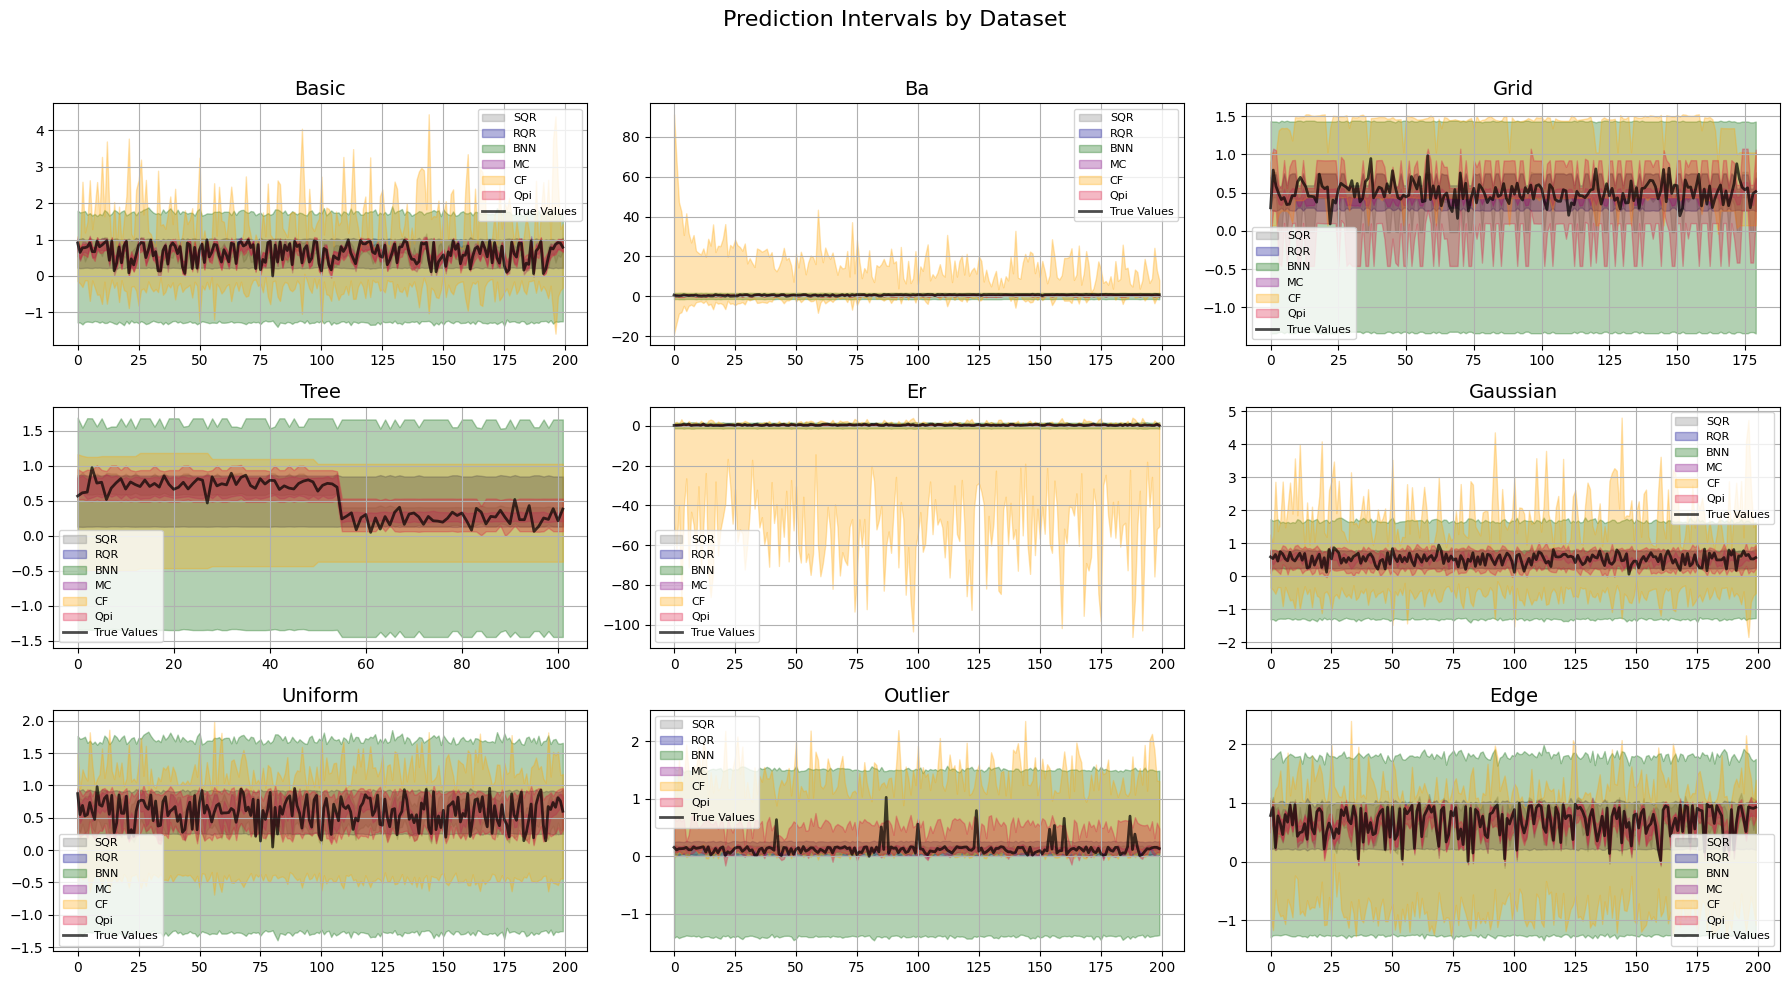

In [40]:
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(3, 3, figsize=(18, 10), sharex=False, sharey=False)
axes = axes.flatten()

for i, dataset_name in enumerate(dataset_list):  # 9개 데이터셋
    ax = axes[i]
    ax.set_title(dataset_name.capitalize(), fontsize=14)

    # 정렬된 true value (정렬 기준 노드 인덱스 가정)
    y = true_values[dataset_name].squeeze()
    min_len = len(y)
    x = np.arange(min_len)

    # 각 모델별 예측 구간 덧씌우기
    for model_name, color in method_colors.items():
        low = all_low_preds[model_name][dataset_name].squeeze()
        upp = all_upp_preds[model_name][dataset_name].squeeze()

        # 방어적 자르기
        min_len = min(len(y), len(low), len(upp))
        ax.fill_between(x[:min_len], low[:min_len], upp[:min_len], color=color, alpha=0.3, label=model_name)

    # 실제 값 선
    ax.plot(x[:min_len], y[:min_len], color='black', linewidth=2, label="True Values", alpha=0.7)

    ax.grid(True)
    ax.legend(fontsize=8)

plt.suptitle("Prediction Intervals by Dataset", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [64]:
def plot_sorted_and_unsorted_intervals(x, y, low, up, raw_y, raw_low, raw_up, label, color):
    fig, axes = plt.subplots(1, 2, figsize=(15, 3))

    # 정렬된 예측 구간
    axes[0].plot(range(len(x)), y, color='gray', label="True Values", linewidth=3, alpha=0.5)
    axes[0].fill_between(range(len(x)), low, up, color=color, alpha=0.5)
    axes[0].set_title(f'{label} Sorted PIs', size=14)
    axes[0].set_xlabel("Sorted Node Index", size=11)
    axes[0].set_ylabel("Values", size=11)

    # 원래 순서
    axes[1].plot(range(len(raw_y)), raw_y, color='gray', label="True Values", linewidth=1, alpha=0.3)
    axes[1].fill_between(range(len(raw_y)), raw_low.squeeze(), raw_up.squeeze(), color=color, alpha=0.5)
    axes[1].set_title(f'{label} PIs', size=14)
    axes[1].set_xlabel("Node Index", size=11)
    axes[1].set_ylabel("Values", size=11)

    plt.tight_layout()
    plt.show()
    plt.close(fig)


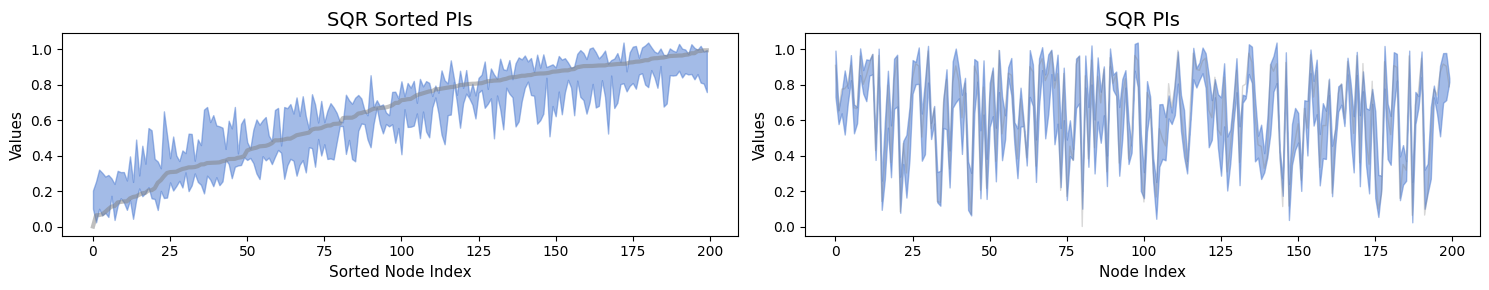

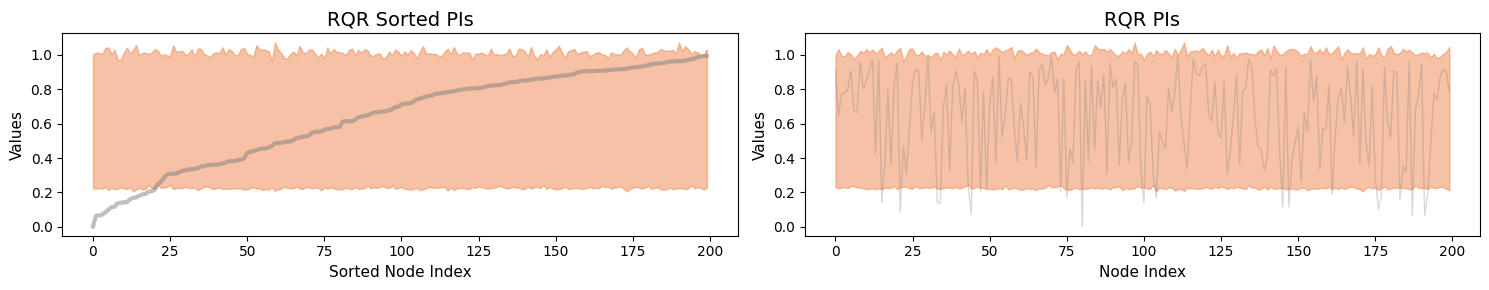

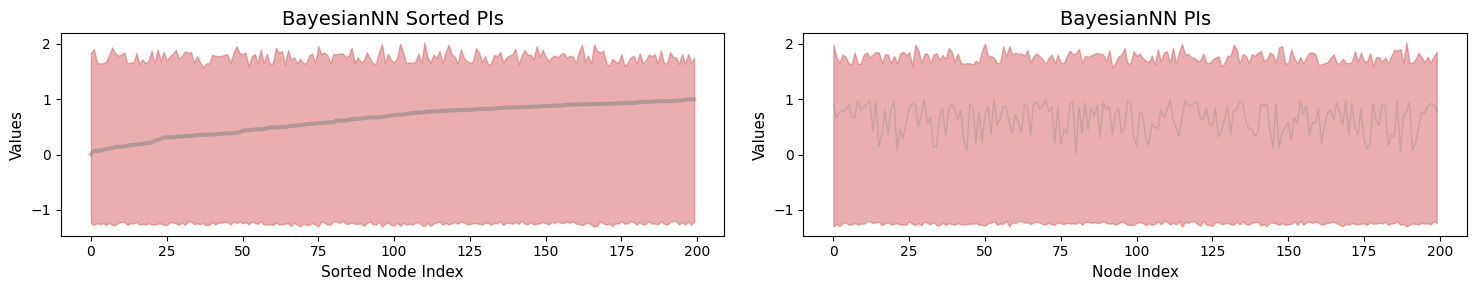

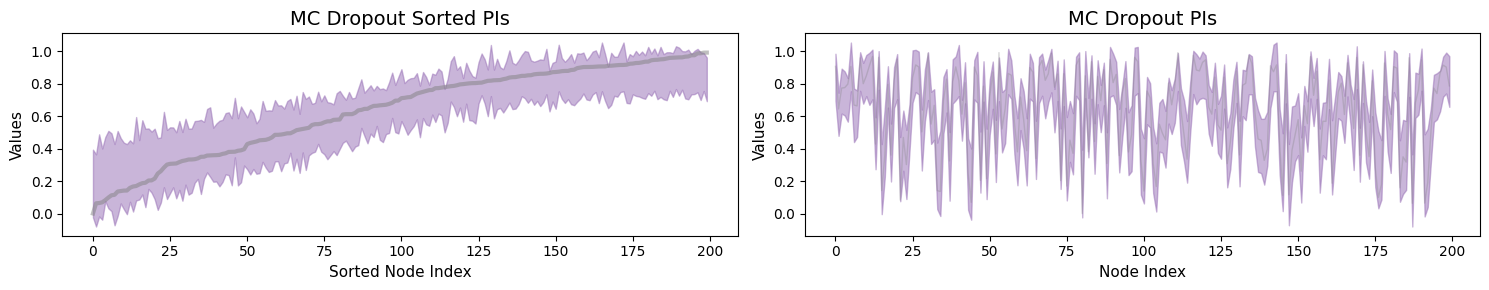

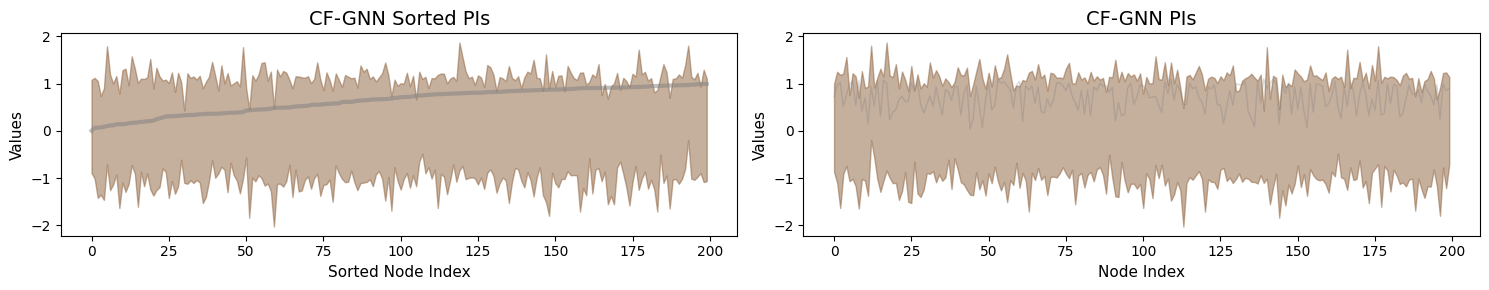

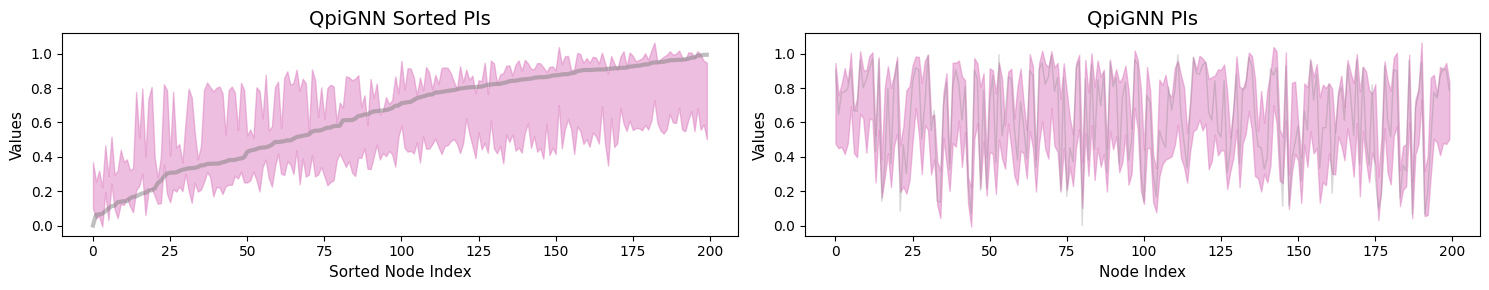

In [65]:
# ======================= SQR =======================
x_sqr, y_sqr, (low_r_sqr, upper_r_sqr) = sort_by_y(test_data.x, test_data.y, test_low_preds_sqr, test_upper_preds_sqr)
plot_sorted_and_unsorted_intervals(x_sqr, y_sqr, low_r_sqr, upper_r_sqr,
                                   test_targets_sqr, test_low_preds_sqr, test_upper_preds_sqr,
                                   label='SQR', color=color_sqr)

# ======================= RQR =======================
x_rqr, y_rqr, (low_r_rqr, upper_r_rqr) = sort_by_y(test_data.x, test_data.y, test_low_preds_rqr, test_upper_preds_rqr)
plot_sorted_and_unsorted_intervals(x_rqr, y_rqr, low_r_rqr, upper_r_rqr,
                                   test_targets_rqr, test_low_preds_rqr, test_upper_preds_rqr,
                                   label='RQR', color=color_rqr)

# ======================= BayesianNN =======================
x_bnn, y_bnn, (low_r_bnn, upper_r_bnn) = sort_by_y(test_data.x, test_data.y, test_low_preds_bnn, test_upper_preds_bnn)
plot_sorted_and_unsorted_intervals(x_bnn, y_bnn, low_r_bnn, upper_r_bnn,
                                   test_targets_bnn, test_low_preds_bnn, test_upper_preds_bnn,
                                   label='BayesianNN', color=color_bnn)

# ======================= MC Dropout =======================
x_mc, y_mc, (low_r_mc, upper_r_mc) = sort_by_y(test_data.x, test_data.y, test_low_preds_mc, test_upper_preds_mc)
plot_sorted_and_unsorted_intervals(x_mc, y_mc, low_r_mc, upper_r_mc,
                                   test_targets_mc, test_low_preds_mc, test_upper_preds_mc,
                                   label='MC Dropout', color=color_mc)

# ======================= CF-GNN =======================
x_cf, y_cf, (low_r_cf, upper_r_cf) = sort_by_y(test_data.x, test_data.y, test_preds_low_cf, test_preds_upper_cf)
plot_sorted_and_unsorted_intervals(x_cf, y_cf, low_r_cf, upper_r_cf,
                                   test_targets_cf, test_preds_low_cf, test_preds_upper_cf,
                                   label='CF-GNN', color=color_cf)

# ======================= QpiGNN =======================
x_qpi, y_qpi, (low_r_qpi, upper_r_qpi) = sort_by_y(test_data.x, test_data.y, test_low_preds_qpi, test_upper_preds_qpi)
plot_sorted_and_unsorted_intervals(x_qpi, y_qpi, low_r_qpi, upper_r_qpi,
                                   test_targets_qpi, test_low_preds_qpi, test_upper_preds_qpi,
                                   label='QpiGNN', color=color_qpi)

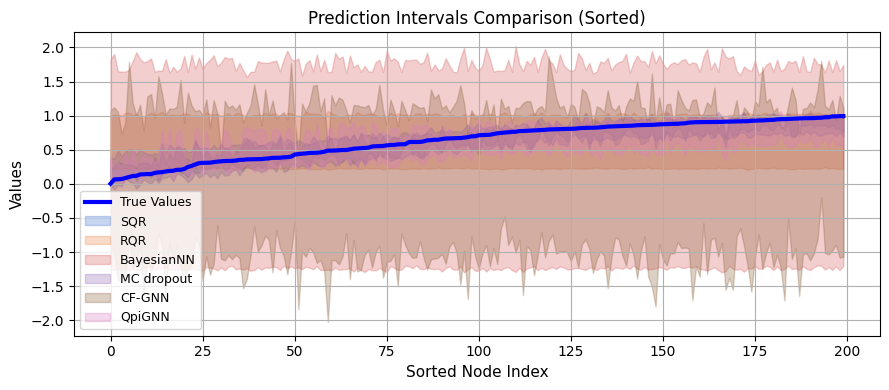

In [108]:
x = range(len(y_sqr))  # x축은 노드 인덱스 (정렬됐다고 가정)

# 접미사별 데이터 구성
method_info = {
    "SQR": {"low": low_r_sqr, "upp": upper_r_sqr, "color": color_sqr},
    "RQR": {"low": low_r_rqr, "upp": upper_r_rqr, "color": color_rqr},
    "BayesianNN": {"low": low_r_bnn, "upp": upper_r_bnn, "color": color_bnn},
    "MC dropout": {"low": low_r_mc, "upp": upper_r_mc, "color": color_mc},
    "CF-GNN": {"low":low_r_cf, "upp": upper_r_cf, "color": color_cf},
    "QpiGNN": {"low": low_r_qpi, "upp": upper_r_qpi, "color": color_qpi},
}

# Plot 시작
plt.figure(figsize=(9, 4))
plt.plot(x, y_sqr, color='blue', label="True Values", linewidth=3)

# 예측 구간 그리기
for method_name, info in method_info.items():
    plt.fill_between(
        x, 
        info["low"], 
        info["upp"], 
        color=info["color"], 
        alpha=0.3, 
        label=method_name
    )

# 스타일
plt.title("Prediction Intervals Comparison (Sorted)", fontsize=12)
plt.xlabel("Sorted Node Index", fontsize=11)
plt.ylabel("Values", fontsize=11)
plt.grid(True)
plt.legend(fontsize = 9)
plt.tight_layout()
plt.show()


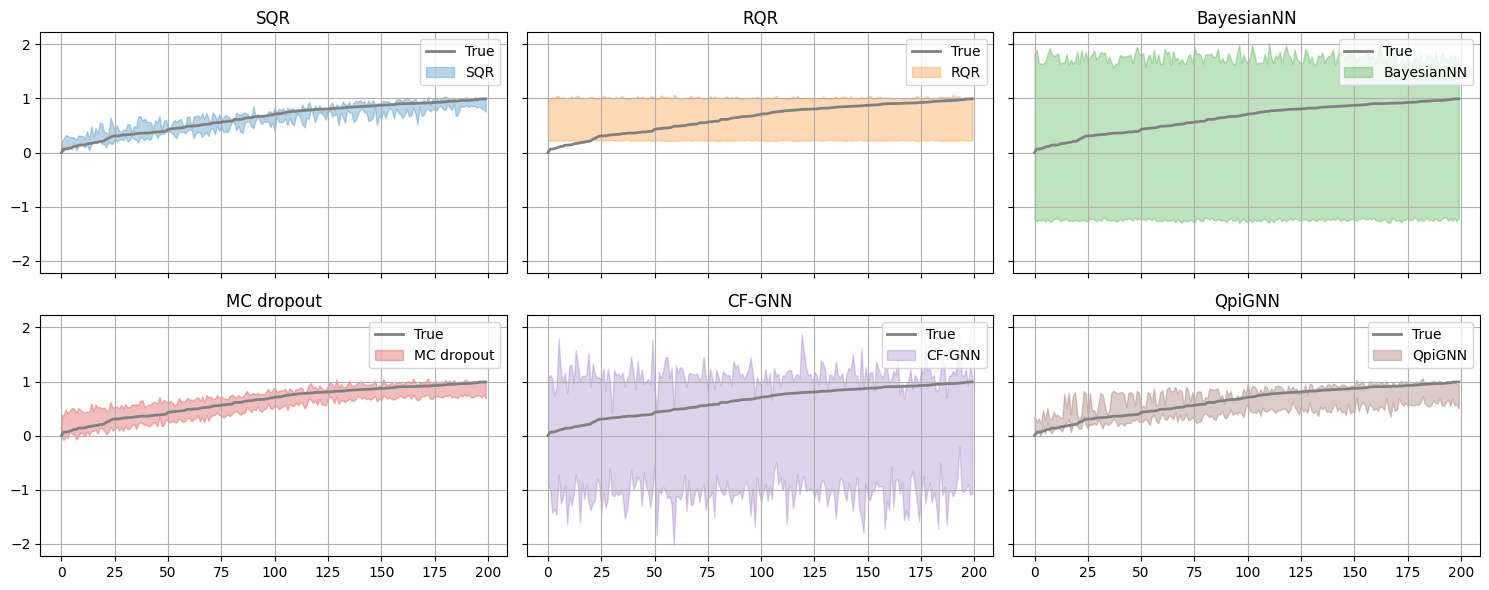

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(15, 6), sharex=True, sharey=True)
axes = axes.flatten()

for idx, (method_name, info) in enumerate(method_info.items()):
    ax = axes[idx]
    ax.plot(x, y_sqr, color='gray', linewidth=2, label='True')
    ax.fill_between(x, info["low"], info["upp"], color=info["color"], alpha=0.3, label=method_name)
    ax.set_title(method_name)
    ax.grid(True)
    ax.legend()

plt.tight_layout()
plt.show()


In [23]:
rename_map = {
    "MC": "MC dropout",
    "BNN":"BayesianNN",
    "CF": "CF-GNN",
    "Qpi": "QpiGNN"
}

for old_name, new_name in rename_map.items():
    all_low_preds[new_name] = all_low_preds.pop(old_name)
    all_upp_preds[new_name] = all_upp_preds.pop(old_name)

KeyError: 'MC'

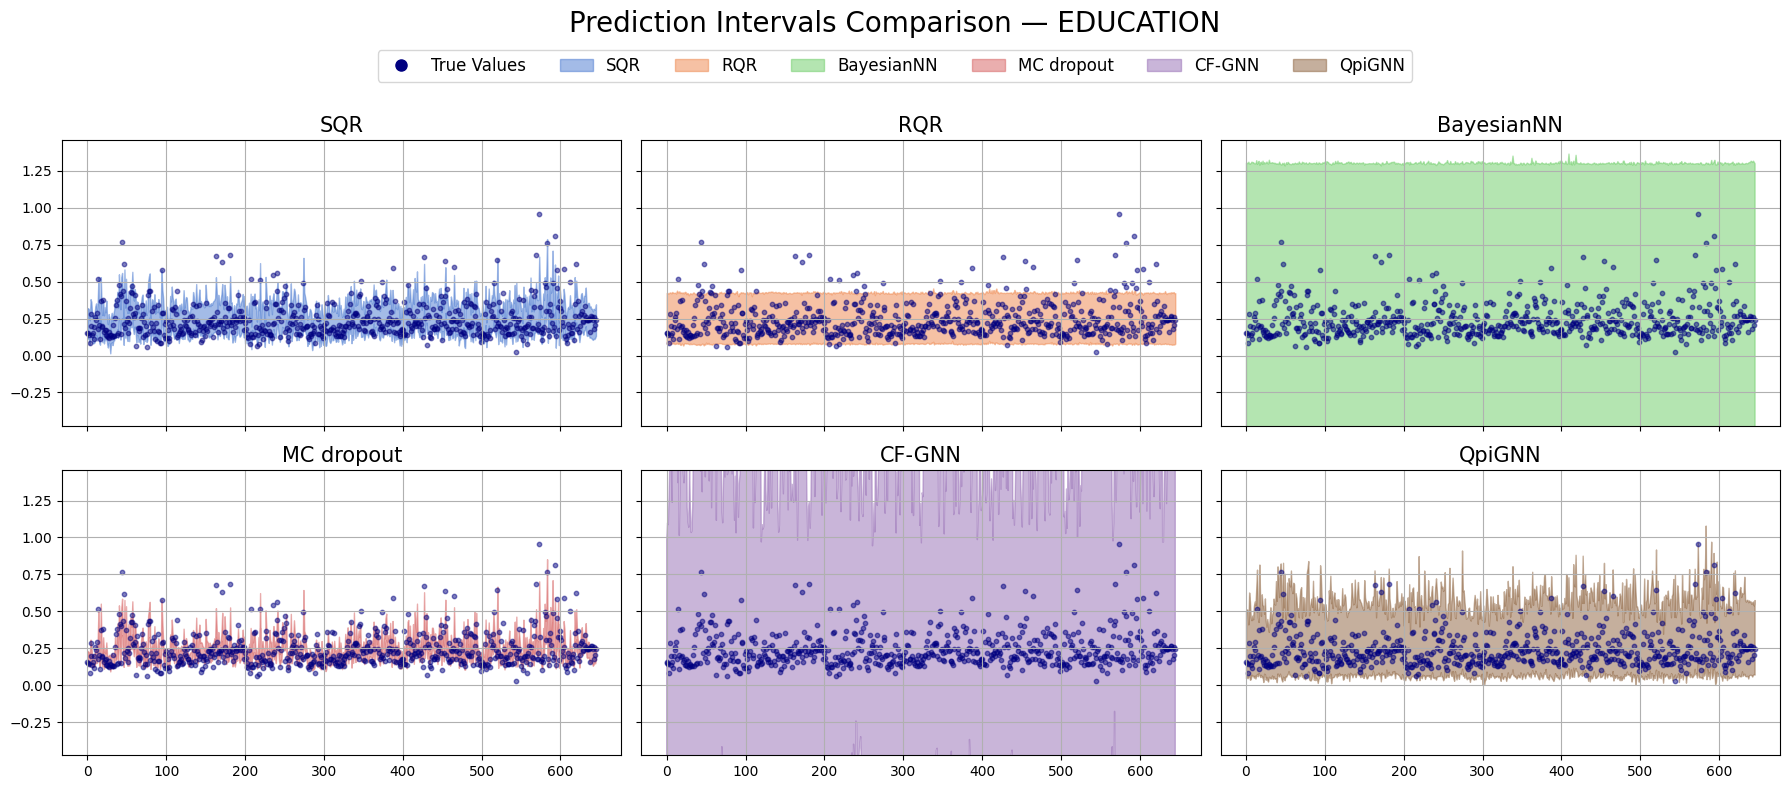

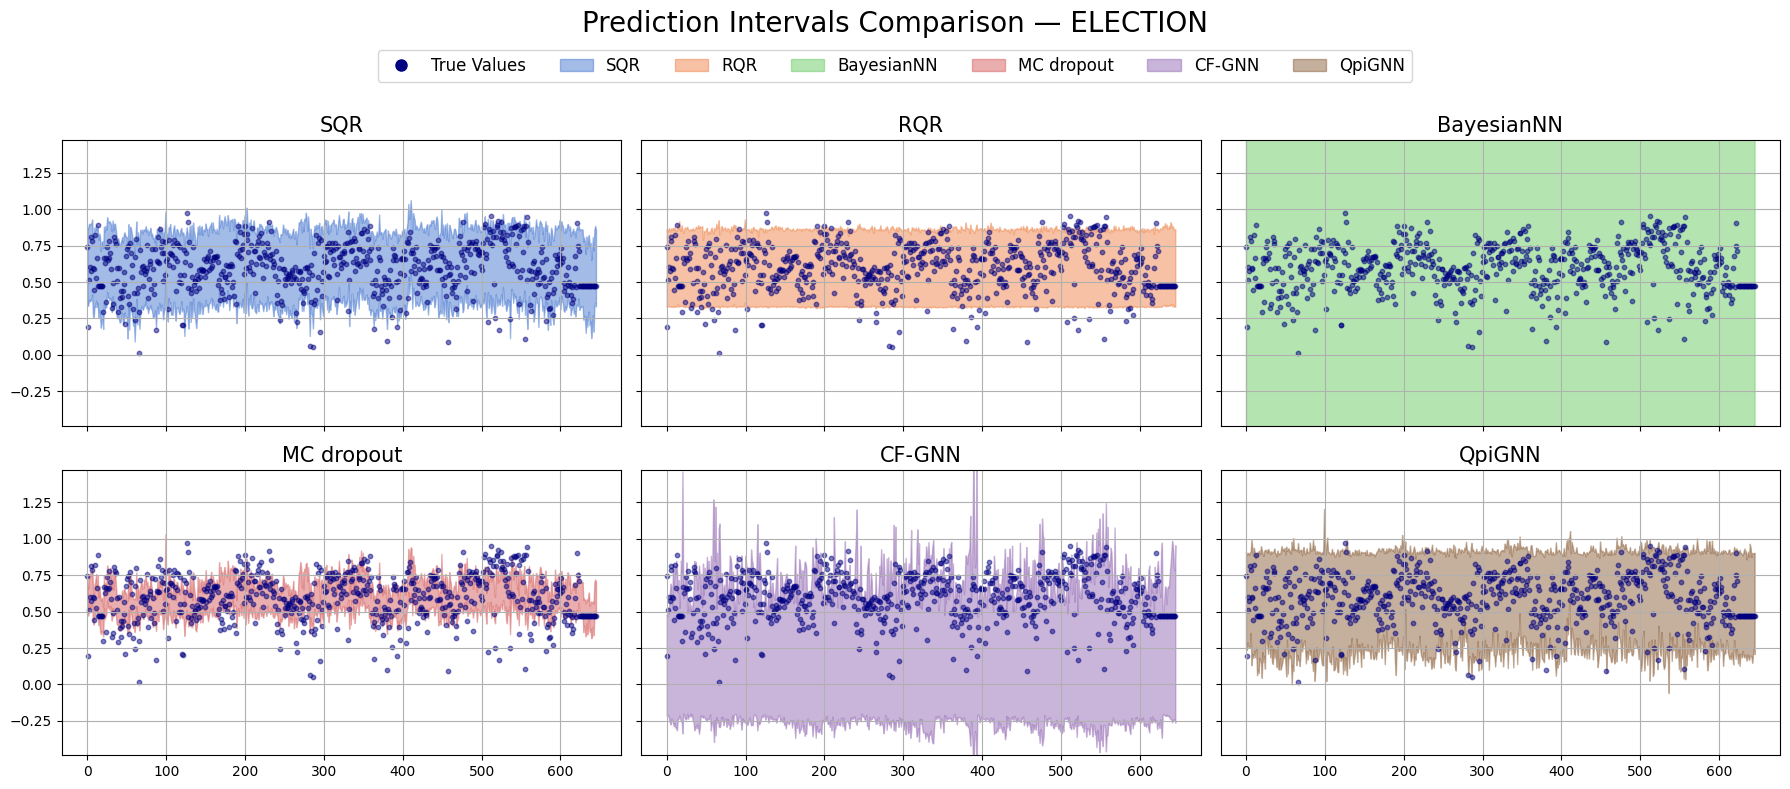

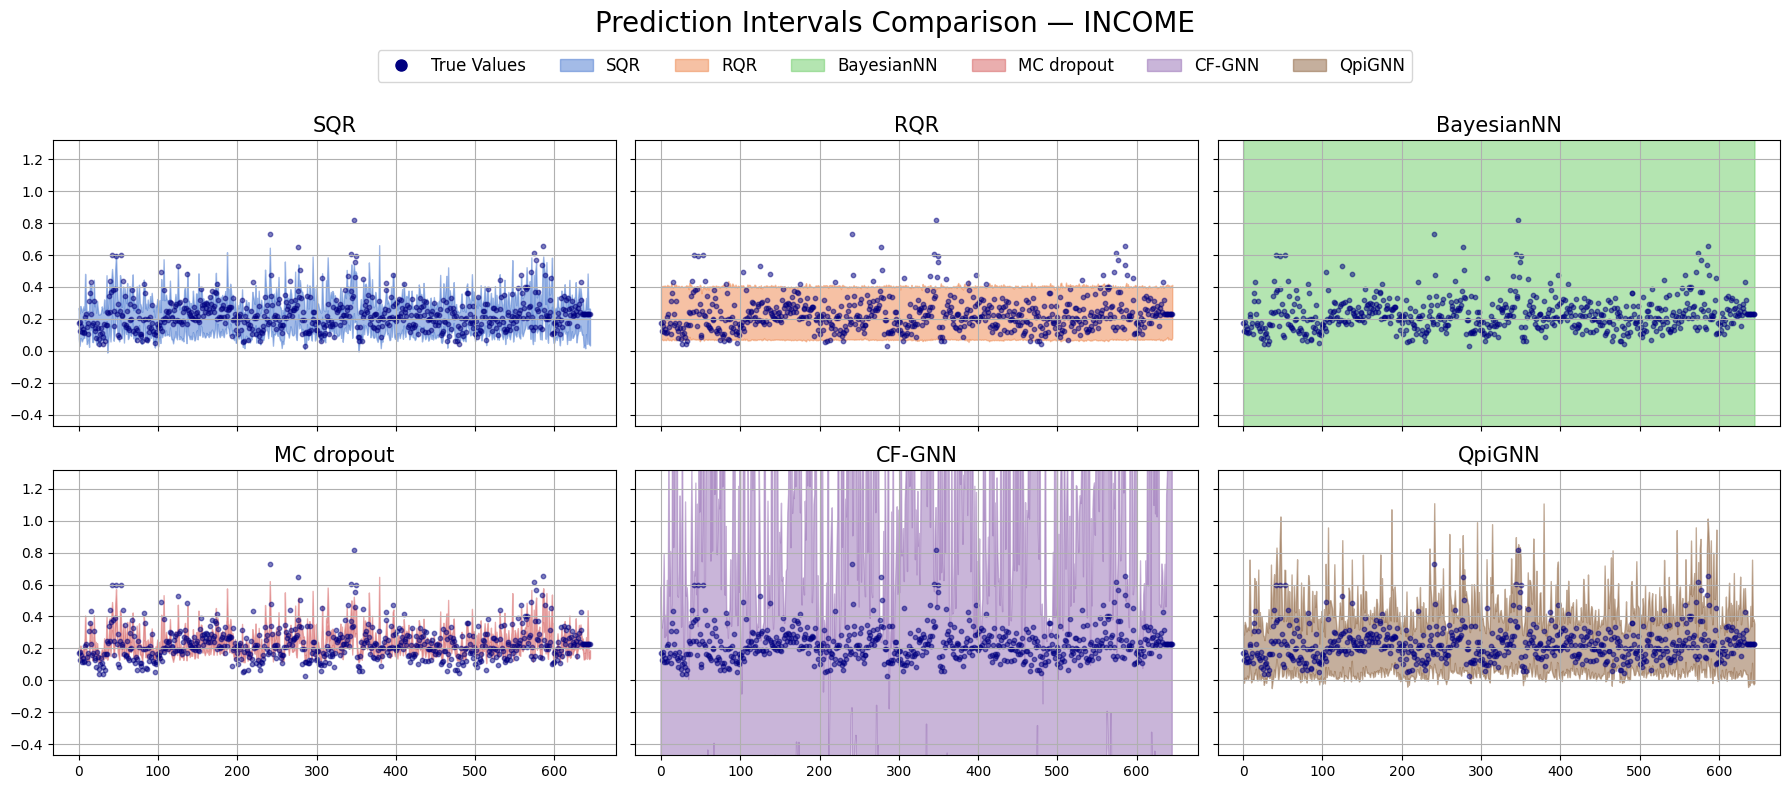

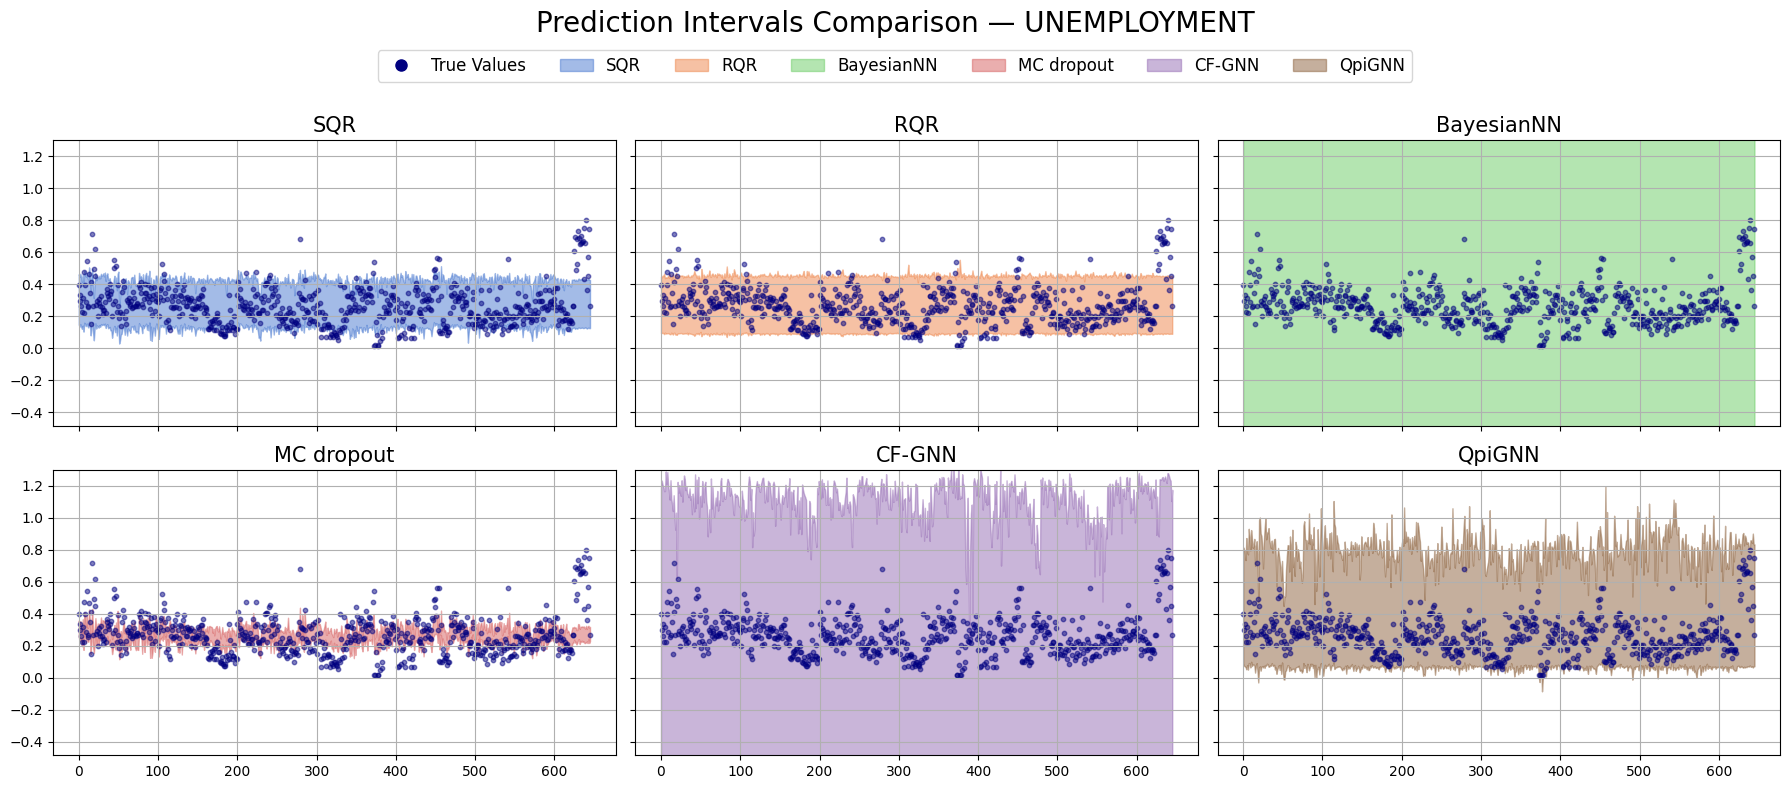

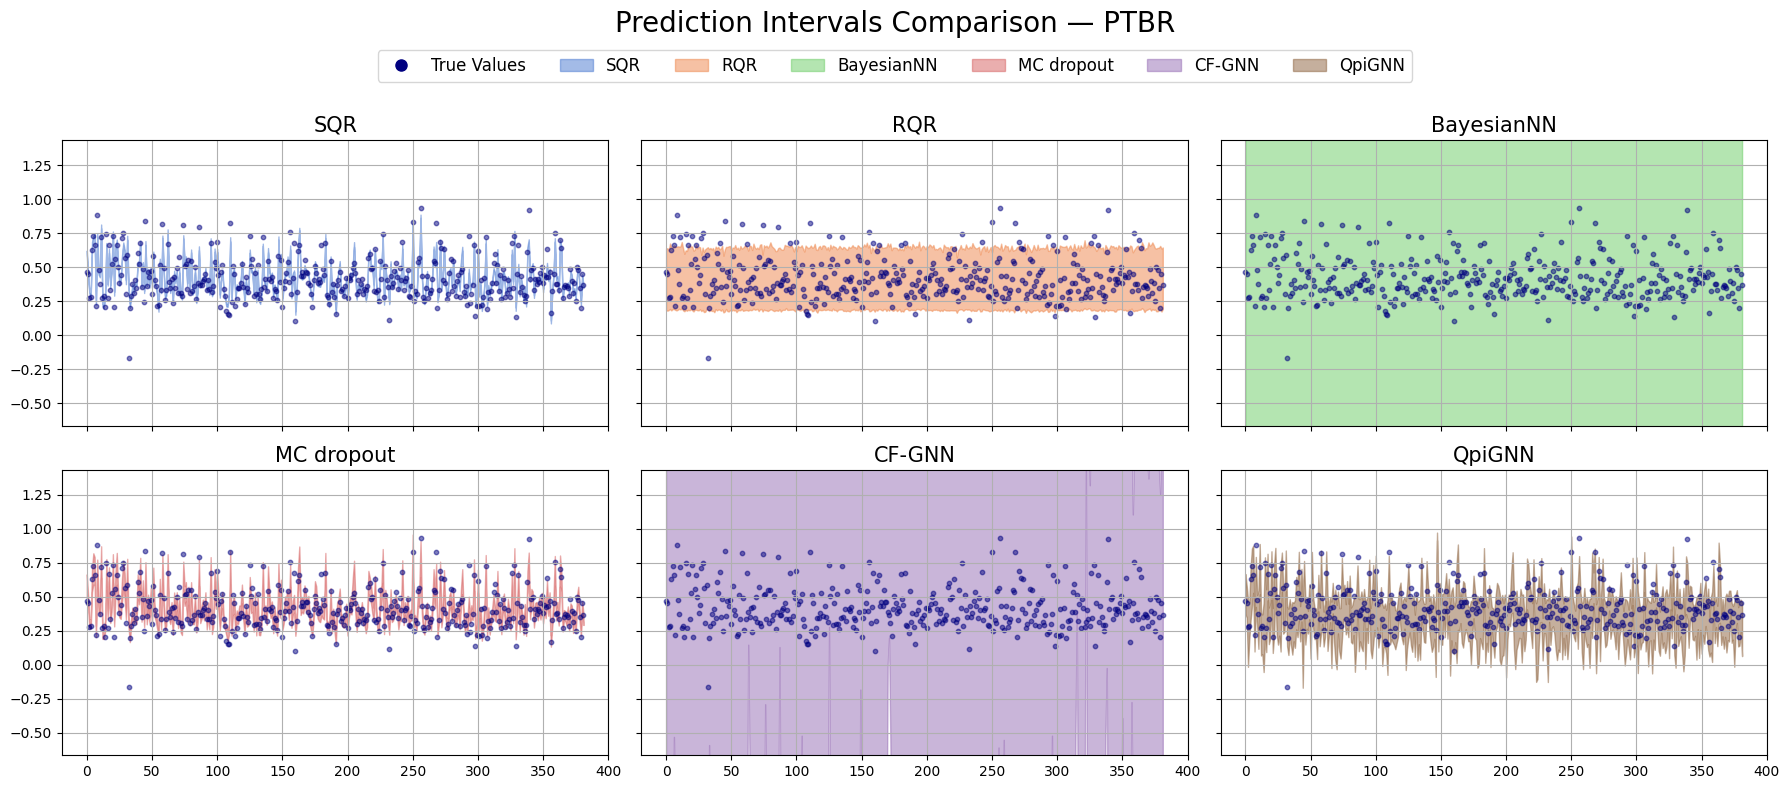

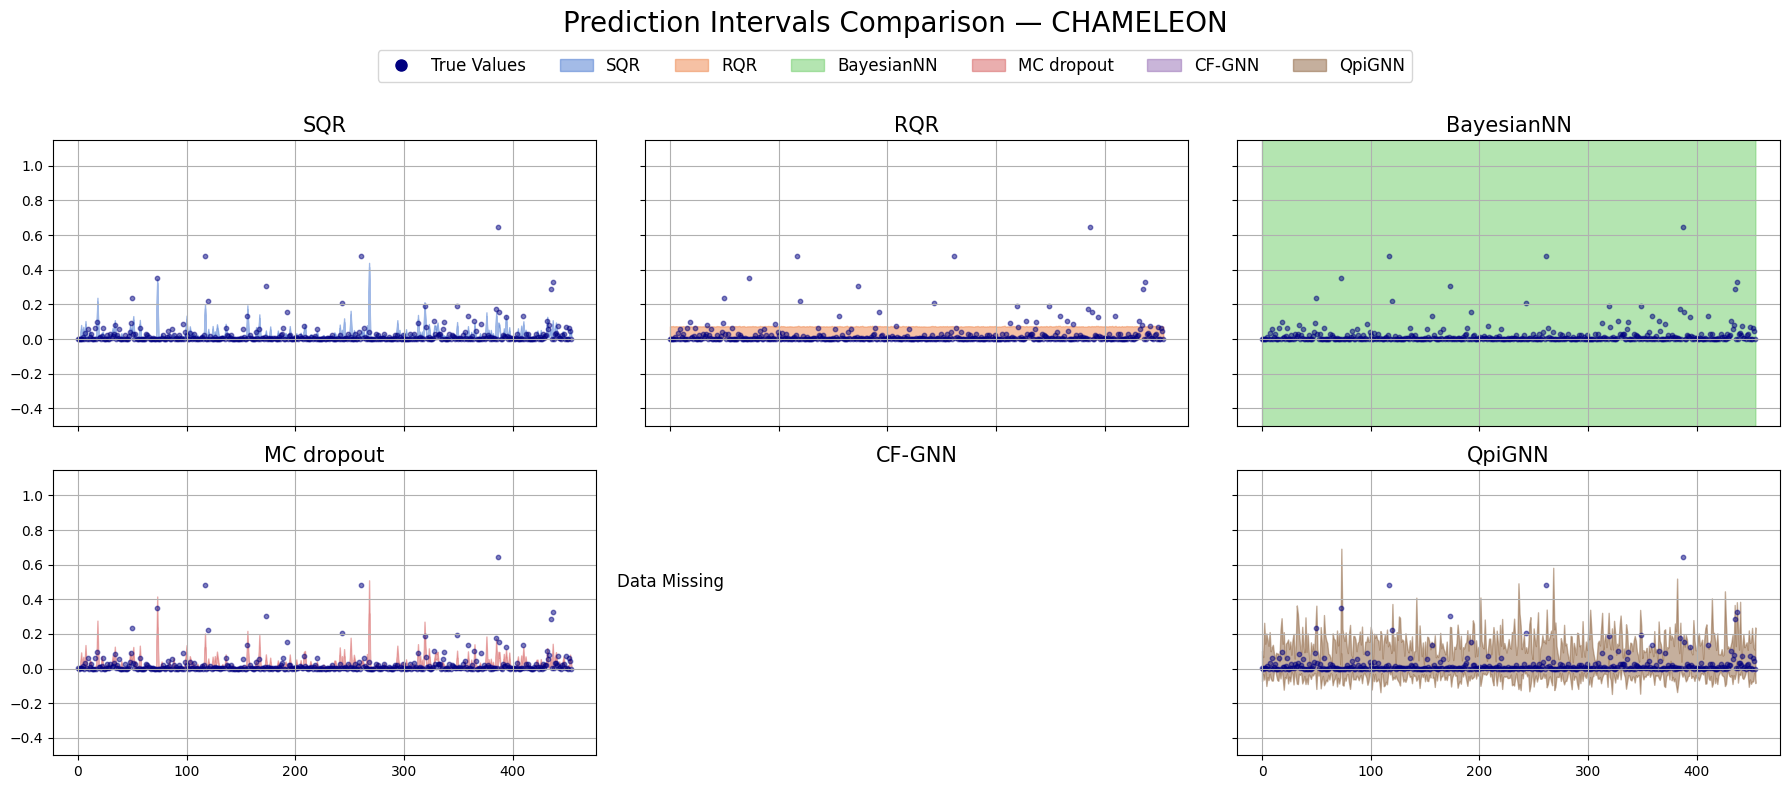

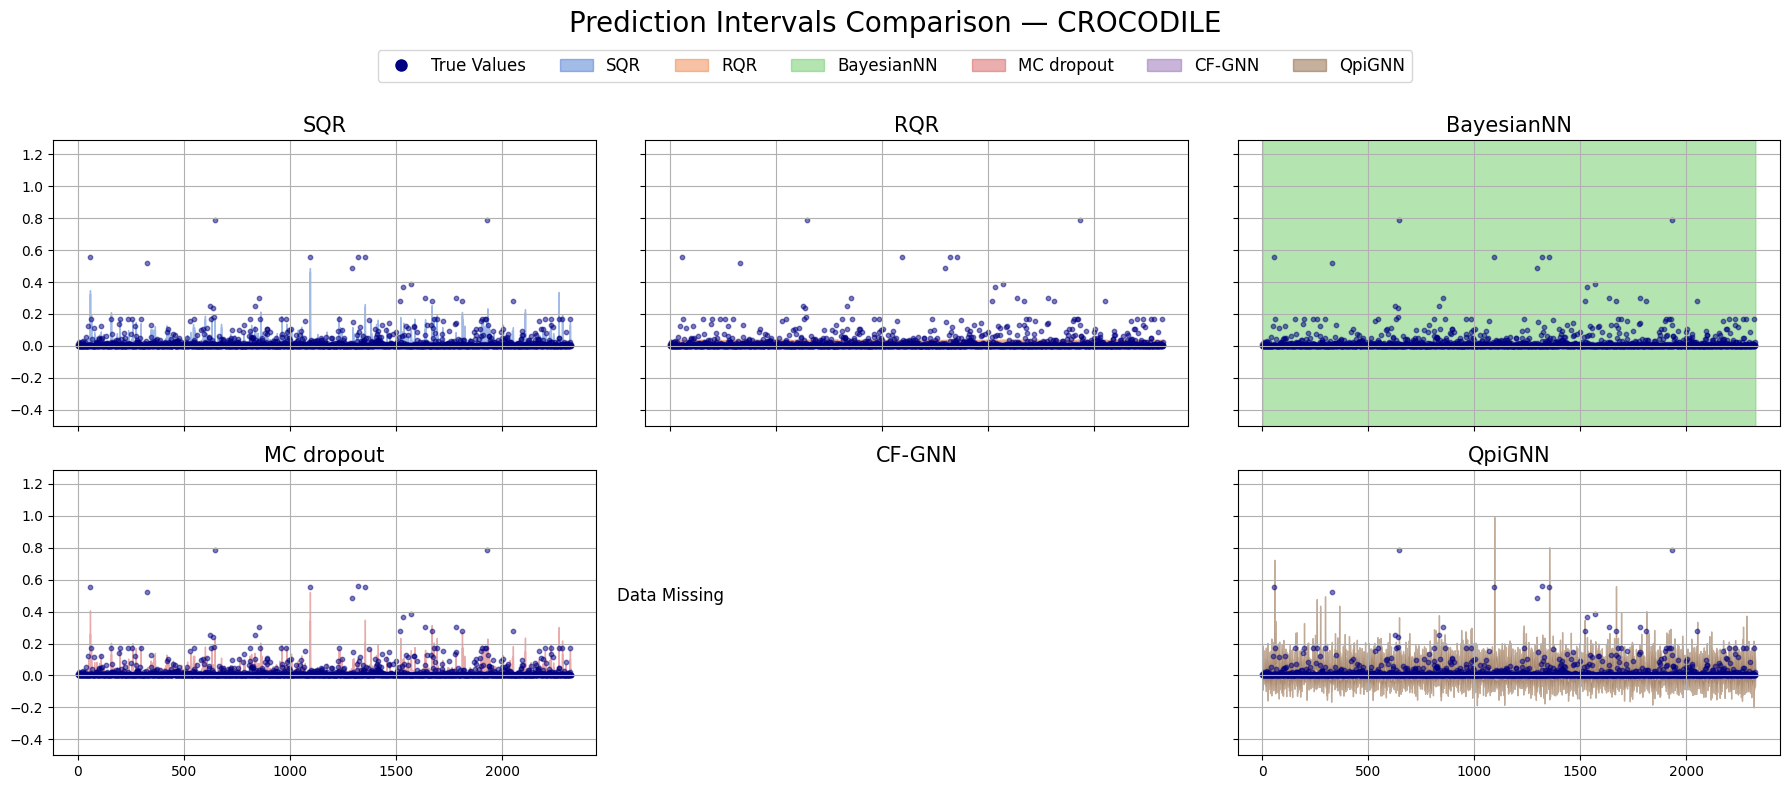

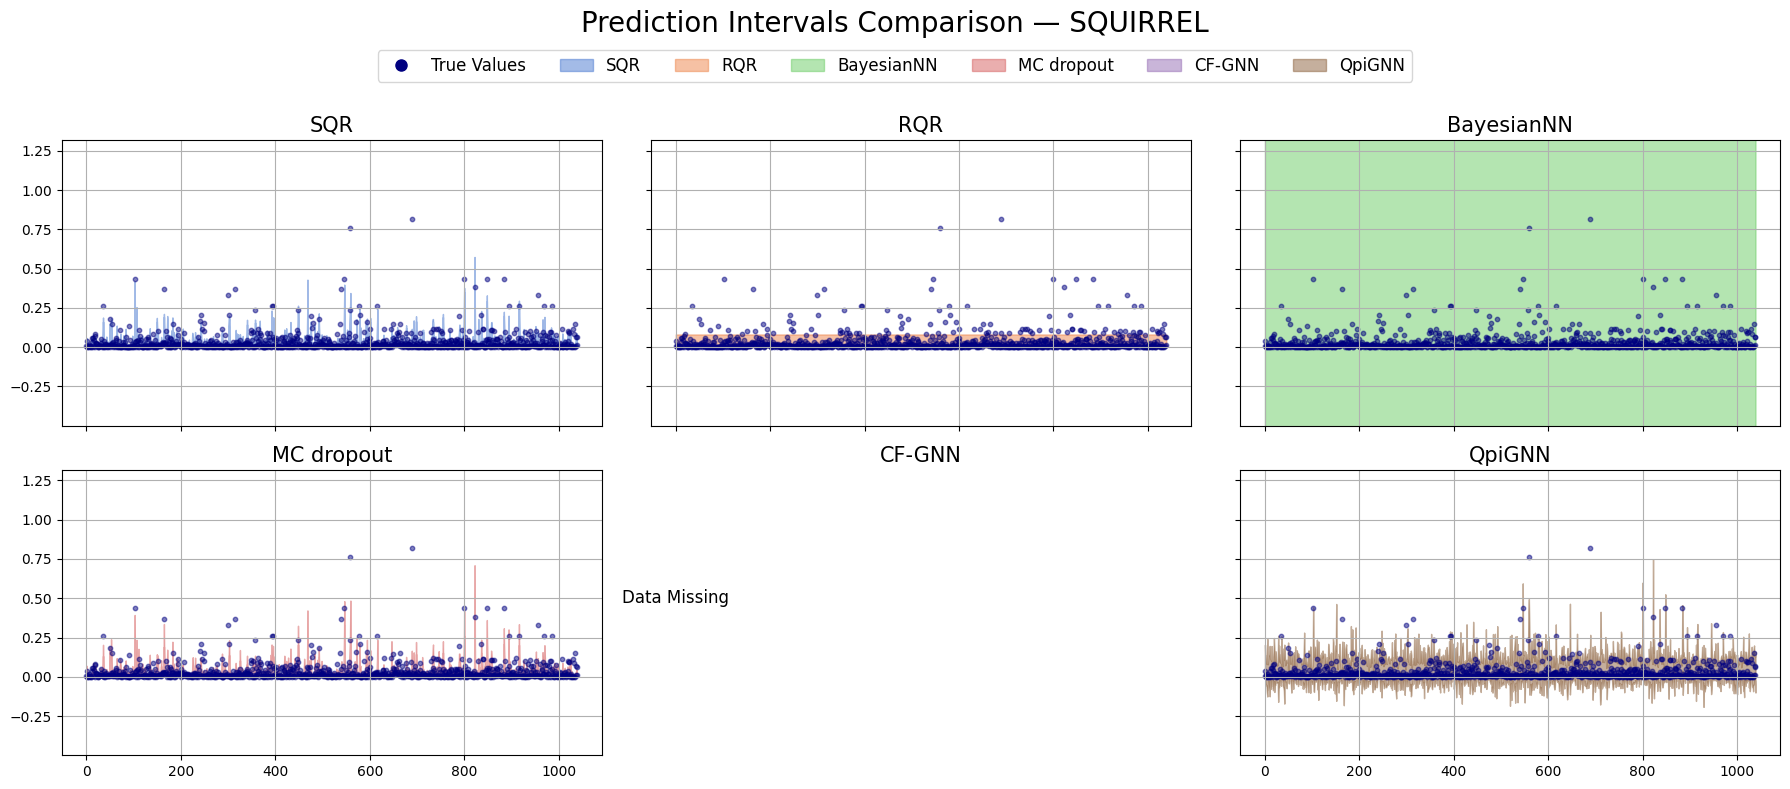

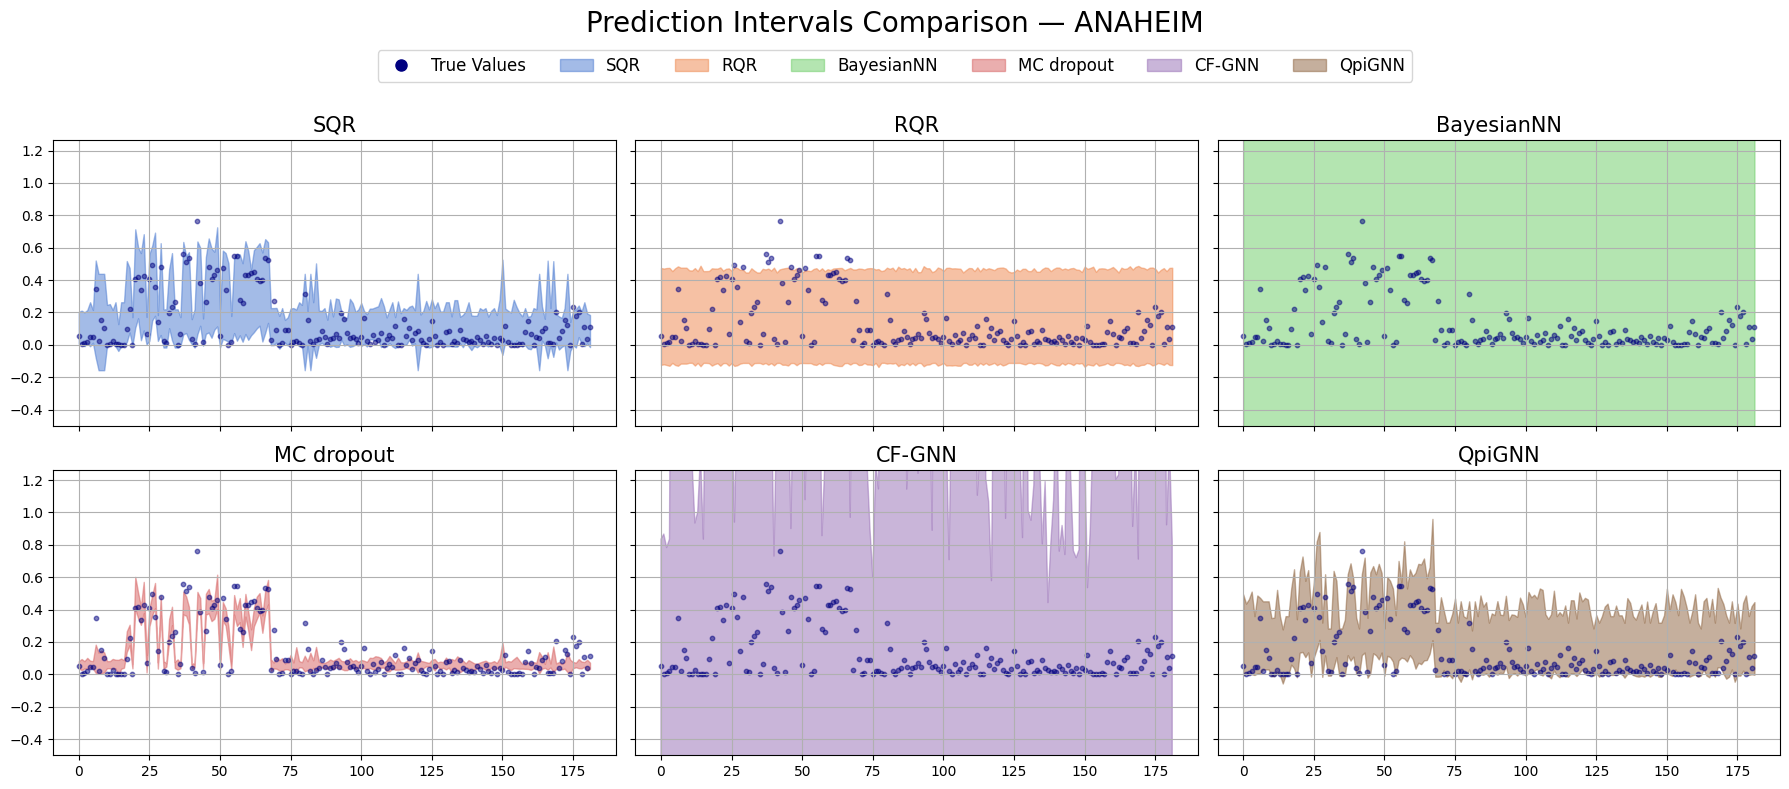

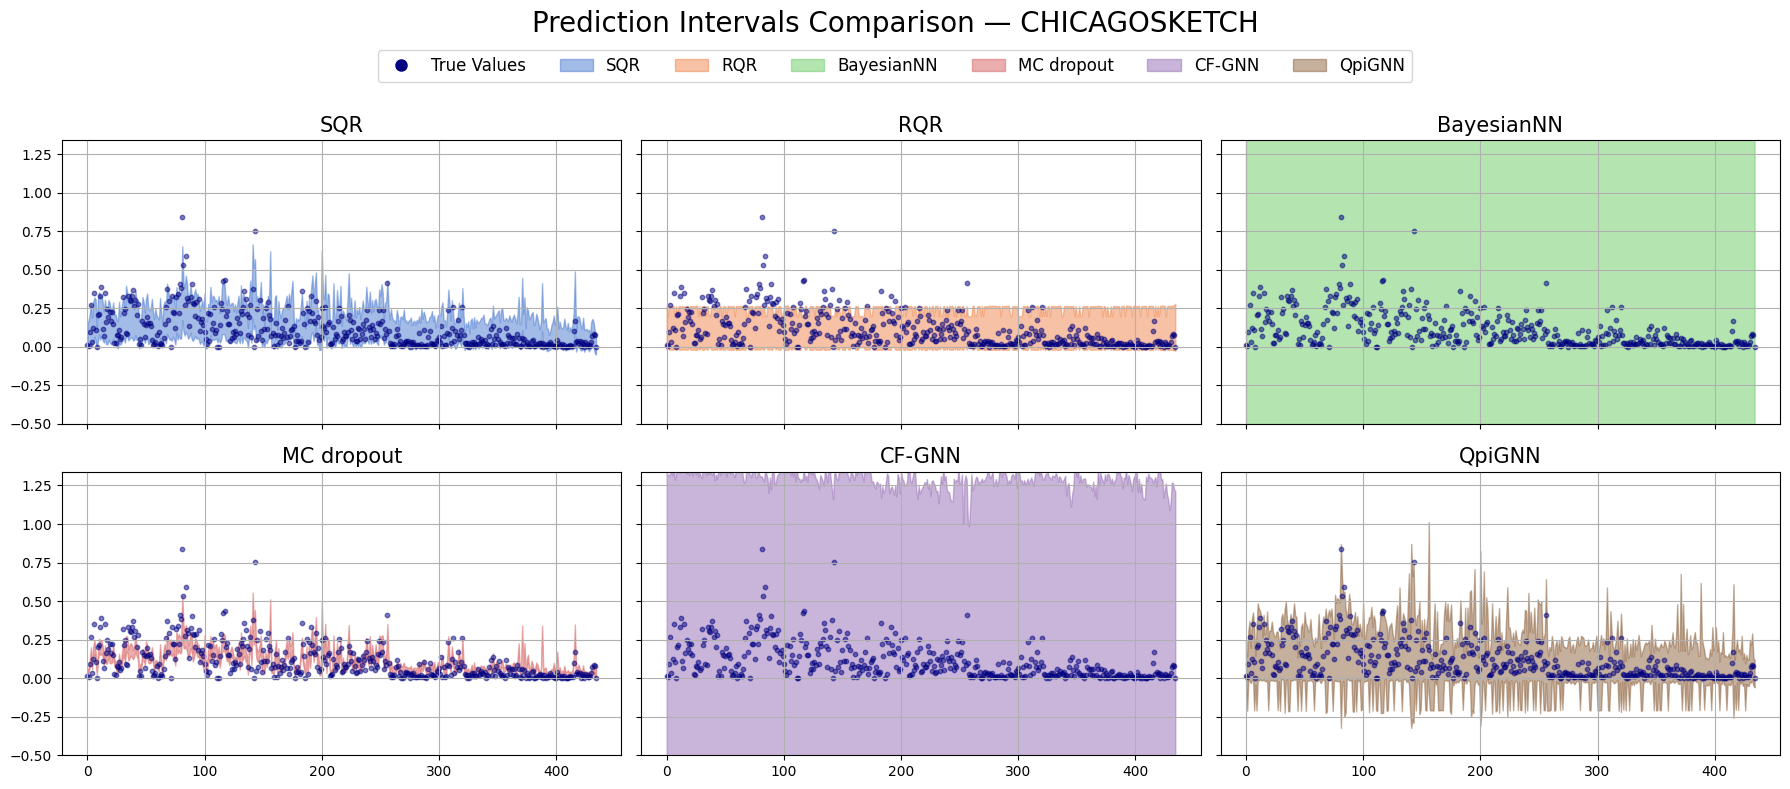

: 

In [ ]:
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D

# method별 색상 설정 (원하는 색상으로 변경 가능)
method_colors = {
    "SQR": color_sqr,
    "RQR": color_rqr,
    "BayesianNN": color_bnn,
    "MC dropout": color_mc,
    "CF-GNN": color_cf,
    "QpiGNN": color_qpi,
}

exclude_cfgnn_datasets = {"chameleon", "crocodile", "squirrel"}

for dataset_name in dataset_list:
    # CF-GNN 제외 조건 적용
    methods_to_plot = [m for m in method_colors if not (dataset_name.lower() in exclude_cfgnn_datasets and m == "CF-GNN")]


    fig, axes = plt.subplots(2, 3, figsize=(18, 8), sharex=True, sharey=True)
    axes = axes.flatten()

    # Ground-truth 값
    y = true_values[dataset_name].squeeze()
    x = np.arange(len(y))

    for i, method in enumerate(method_colors.keys()):
        ax = axes[i]
        ax.set_title(method, fontsize=15)
        
        if dataset_name not in all_low_preds[method] or dataset_name not in all_upp_preds[method]:
            ax.text(0.5, 0.5, 'Data Missing', ha='center', va='center', fontsize=12)
            ax.axis('off')
            continue

        low = all_low_preds[method][dataset_name].squeeze()
        upp = all_upp_preds[method][dataset_name].squeeze()

        min_len = min(len(x), len(y), len(low), len(upp))
        x_plot = x[:min_len]
        y_plot = y[:min_len]
        low_plot = low[:min_len]
        upp_plot = upp[:min_len]

        ax.fill_between(x_plot, low_plot, upp_plot, color=method_colors[method], alpha=0.5)
        ax.scatter(x_plot, y_plot, color='navy', s=10, alpha=0.5)

        y_min = y_plot.min() - 0.5
        y_max = y_plot.max() + 0.5
        ax.set_ylim(y_min, y_max)

        ax.grid(True)

    # ✅ 범례는 전체 figure에 한 번만 추가
    legend_handles = [
    Line2D([0], [0], marker='o', color='navy', label='True Values', linestyle='', markersize=8)
    ] + [
    mpatches.Patch(color=color, label=name, alpha=0.5)
    for name, color in method_colors.items()]


    fig.suptitle(f"Prediction Intervals Comparison — {dataset_name.upper()}", fontsize=20)
    fig.tight_layout(rect=[0, 0, 1, 0.92])  # 제목 공간을 위해 위쪽 padding 늘림

    fig.legend(handles=legend_handles,
            loc='upper center',
            ncol=7,
            fontsize=12,
            bbox_to_anchor=(0.5, 0.94))  # 0.94는 suptitle 바로 아래 지점

    plt.savefig(f"pred/qa/pi_models_{dataset_name}.png", dpi=300)
    plt.show()

